#### Aim: find if CHO cells have endogenous retrovirus.

In [1]:
import os,sarge,re
import pandas as pd
from Bio import SeqIO
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('ggplot')
from pybedtools import BedTool
from natsort import natsorted
import glob
import numpy as np
import pysam

### Map virus proteins to hamster genome
1. download all endogenous retroirus in ncbi here: https://www.ncbi.nlm.nih.gov/genomes/GenomesGroup.cgi?taxid=11632. There are 66 retrovirus by the time (2017/12) I downloaded. 
2. Map the proteins to hamster reference genome.

In [2]:
path = '/data/shangzhong/Proteogenomics/virus'
pasa_path = '/data/shangzhong/Picr_assembly/Annotation/PASA/pasa_stringtie'
event_path = '/data/shangzhong/Proteogenomics/event_results'
ham_blastdb = '/data/genome/hamster/picr_old/picr_blast_Db/picr'
ham_fa = '/data/genome/hamster/picr_old/picr.fa'
ham_gff = pasa_path + '/03_pasa_stringtie.gff3'
rna_fa = pasa_path + '/03_pasa_stringtie_rna.fa'
thread = 19
uniprot_fa_fn = pasa_path + '/uniprot_sprot.fasta'
uniprot_id_map = pasa_path + '/uniprot_idmap.txt' # accession:gene name mapping
known_pep_pos_fn = event_path + '/known_pos.txt'
cho_known_pep_pos_fn = event_path + '/cho_known_pos.txt'

First, we extract CHO peptides from the original peptide results

In [3]:
tissue_fns = ['spectrum-' + str(i).zfill(5) + '.mgf' for i in range(343, 439)]
# 1. get cho map results
if not os.path.exists(cho_known_pep_pos_fn):
    df = pd.read_csv(fn,sep='\t',header=0)
    df = df[~df['#SpecFile'].isin(tissue_fns)]
    df.to_csv(cho_known_pep_pos_fn,sep='\t',index=False)
# 2. get cho novel peptides
novel_res = event_path + '/novel_res.txt'
novel_res_df = pd.read_csv(novel_res, sep='\t',header=0)

novel_res_df = novel_res_df[~novel_res_df['#SpecFile'].isin(tissue_fns)]
novel_res_df = novel_res_df.reset_index(drop=True)
novel_res_df['pep'] = novel_res_df['Peptide'].map(lambda x: ''.join([p for p in x if p.isalpha()][:-1]))
cho_novel_peps = novel_res_df['pep'].unique().tolist()

In [4]:
# blast peptides to virus
def makeblastdb(fastaFile,datatype,out_path,outputname):
    """
    this function build database given a fasta file
    * fastaFile: can be gzipped or not
    """
    if not os.path.exists(out_path):os.mkdir(out_path)
    os.chdir(out_path)
    if fastaFile.endswith('.gz'):
        cmd = ('gunzip -c {input} | makeblastdb -in - -dbtype {type} -title {title} -out {outputname}').format(
            input=fastaFile,type=datatype,outputname=outputname,title=outputname)
    else:
        cmd = ('makeblastdb -in {input} -dbtype {type} -title {title} -out {outputname}').format(
            input=fastaFile,type=datatype,outputname=outputname,title=outputname)
    sarge.run(cmd)
    
def blastp(query,outputFile,database,thread,mapnum=1):
    """
    This function run blastp
    * query: fasta file which you want to map
    * database: database path/name
    * outputFile: tabular blast result
    """
    cmd = ('blastp -query {inf} -db {database} -out {outputFile} '
           '-outfmt \'6 qacc sacc pident length mismatch '
           'gapopen qstart qend sstart send evalue bitsocre qlen slen\' '
           '-num_threads {thread} -num_alignments {mapnum}').format(inf=query,
                database=database,outputFile=outputFile,thread=str(thread),mapnum=str(mapnum))
    print(cmd)
    sarge.run(cmd)
    
def blastn(query,outputFile,database,thread,mapnum=1):
    ''''''
    cmd = ('blastn -query {inf} -db {database} -out {out} -evalue 1e-4 '
           '-outfmt \'6 qacc sacc pident length mismatch '
           'gapopen qstart qend sstart send evalue bitscore qlen slen\' '
          '-num_threads {thread} -num_alignments {mapnum}').format(inf=query,
                database=database,out=outputFile,thread=str(thread),mapnum=str(mapnum))
    print cmd
    sarge.run(cmd)

def tblastn(query,output,database,thread,mapnum=1):
    cmd = ('tblastn -query {q} -db {db} -out {out} -outfmt \'6 qacc sacc pident length mismatch '
                   'gapopen qstart qend sstart send evalue bitscore qlen slen\' -num_threads {t} '
          '-num_alignments {num}').format(
            q=query,db=database,out=output,t=str(thread),num=1000)
    sarge.run(cmd)
#     print cmd

def add_strand_pst2blast(df):
    '''add percentage of query that is mapped and strand info to df'''
    df['qstart'] -= 1
    df['qlen_per'] = (df['qend']-df['qstart'])/df['qlen']
    df['start'] = df.apply(lambda x: min(int(x['sstart']),int(x['send']))-1,axis=1)
    df['end'] = df.apply(lambda x: max(int(x['sstart']),int(x['send'])),axis=1)
    df['strand'] = df.apply(lambda x:'+' if int(x['send'])>int(x['sstart']) else '-',axis=1)
    return df

In [5]:
# generate virus accession, genename, virus mapping
def get_virus_acc_name(virus_acc_name_map_fn):
    if not os.path.exists(virus_acc_name_map_fn):
        with open(virus_acc_name_map_fn,'w') as out:
            for record in SeqIO.parse(query,'fasta'):
                pid = record.id
                des = record.description.lower()
                handle = Entrez.efetch(db='protein',id=pid,rettype='gb',retmode='text')
                res = handle.read()
                if 'gag-pro-pol' in des:
                    name = 'gag-pro-pol'
                elif 'gag' in des:
                    name = 'gag'
                elif 'envelope' in des or 'env' in des:
                    name = 'env'
                elif 'pol ' in des:
                    name = 'pol'
                elif 'hypothetical protein' in des:
                    name = 'gag'
                else:
                    name = ' '.join(des.split()[1:-1])
                try:
                    name1 = re.search('(?<=gene=\").+?(?=\")',res).group(0)
                except:
                    name1 = name
                virus = re.search('(?<=\[).+?(?=\])',des).group(0)
                out.write('\t'.join([virus,pid,name1])+'\n')
    # build {virus:genename} dictionary
    df = pd.read_csv(virus_acc_name_map_fn,sep='\t',header=None,names=['virus','pid','name'])
    virus_name_dic = df.set_index('pid')['name'].to_dict()
    return virus_name_dic
from Bio import Entrez
Entrez.email = 'shl198@eng.ucsd.edu'
virus_acc_name_map_fn = path + '/02_virus_acc_name_map.txt'
if not os.path.exists(virus_acc_name_map_fn):
    virus_name_dic = get_virus_acc_name(virus_acc_name_map_fn)
else:
    df = pd.read_csv(virus_acc_name_map_fn,sep='\t',header=None,names=['virus','pid','name'])
    virus_name_dic = df.set_index('pid')['name'].to_dict()

In [6]:
# map virus protein to picr genome using tblastn
query = path + '/02_retro_virus_pr.fa'
virus_nr2picr_fn = path + '/03_virus_pr2picr_nt.txt'
if not os.path.exists(virus_nr2picr_fn):
    tblastn(query,virus_nr2picr_fn,ham_blastdb,thread,mapnum=1000)

### Detect LTR in picr genome using LTRharvest. LTR is the element that regulate retrovirus gene expression. So the virus mapping to regions between LTR have higher probability to be the retrovirus that produce proteins.

In [7]:
def generate_ltr_index(fa,name):
    '''generate index'''
    cmd = ('gt suffixerator -db {fa} -indexname {name} -tis -suf -lcp -des -ssp -sds -dna -lossless -v').format(
                fa=fa,name=name)
    print cmd
    sarge.run(cmd)
    
def run_ltr_harvest(index,gff,out_fa,out,thread):
    cmd = ('gt -j {t} ltrharvest -index {idx} -mintsd 5 -maxtsd 20 -motif tgca '
          '-out {out_fa} -v -gff3 {gff} > {out}').format(t=str(thread),idx=index,
                out_fa=out_fa,gff=gff,out=out)
    print(cmd)
    sarge.run(cmd)

ltr_fn = path + '/04_LTR_res.txt'
ltr_fa = path + '/04_LTR.fa'
ltr_gff =path + '/04_LTR.gff3'
if not os.path.exists(ltr_fn):
    # 1. build index
    index_name = path + '/ltr_index/ltr_index'
    if not os.path.exists(index_name):
        generate_ltr_index(ham_fa,index_name)
    # 2. run ltrharvest
    run_ltr_harvest(index_name,ltr_gff,ltr_fa,ltr_fn,thread)

### Get translated retrovirus genes in the reference annotation file
In the annotation we generated, there are already some retrovirus genes. So first, we need to check if there are any spectrum mapping to the known proteins.

In [8]:
def get_uniprot_nm_acc_dic(dic,fn):
    '''{genename: uniprot accession}
    dic: here we put it here so that it can merge multiple dictionary together
    '''
    with open(fn) as f:
        for line in f:
            item = line.strip().split('\t')
            dic[item[1]] = item[-1]
    return dic

def get_virus_gene_in_annotation(ham_gff,uni_nm_acc_fn1,uni_nm_acc_fn2,uniprot_fa_fn):
    # 1. extract all gene names from hamster annotation
    df = pd.read_csv(ham_gff,sep='\t',header=None,comment='#')
    df = df[df[2].values=='gene']
    gnms = df[8].map(lambda x: re.search('(?<=Name=).+?(?=$|;)',x).group(0)).unique().tolist()
    # 2. {gene name: uniprot gene accession}
    uniprot_nm_acc_dic = {}
    uniprot_nm_acc_dic = get_uniprot_nm_acc_dic(uniprot_nm_acc_dic,uni_nm_acc_fn1)
    uniprot_nm_acc_dic = get_uniprot_nm_acc_dic(uniprot_nm_acc_dic,uni_nm_acc_fn2)
    # 3. get full gene name and extract virus genes
    uni_index = SeqIO.index(uniprot_fa_fn,'fasta')
    virus_genes = {}
    n = 0
    for g in gnms:
        try:
            name = uni_index[uniprot_nm_acc_dic[g]].description
            n += 1
        except:
            name = ''
        if 'virus' in name:
            virus_genes[g] = name
    print 'there are',len(virus_genes),'virus genes in the annotated genome'
    return virus_genes, uniprot_nm_acc_dic
    
uni_nm_acc_fn1 = pasa_path + '/transdecoder/map2uniname_acc.txt'
uni_nm_acc_fn2 = pasa_path + '/10_update_gnm.txt'
virus_genes_in_hamster = path + '/05_virus_genes_in_hamster.txt'
virus_genes, uni_nm_acc_dic = get_virus_gene_in_annotation(ham_gff,uni_nm_acc_fn1,uni_nm_acc_fn2,uniprot_fa_fn)
if not os.path.exists(virus_genes_in_hamster):
    with open(virus_genes_in_hamster,'w') as out:
        for k,v in virus_genes.iteritems():
            out.write(k+'\t'+v+'\n')

there are 41 virus genes in the annotated genome


In [9]:
# the above genes dictionaries are just used to get which gene name belong to retro virus, 
# the full name cannot be used, because sometimes a gene name map to many gene ids.
virus_genes

{'BA71V-079': 'sp|Q65169|VF602_ASFB7 Protein B602L OS=African swine fever virus (strain Badajoz 1971 Vero-adapted) GN=Ba71V-079 PE=3 SV=1',
 'BNIP2': 'sp|O54940|BNIP2_MOUSE BCL2/adenovirus E1B 19 kDa protein-interacting protein 2 OS=Mus musculus GN=Bnip2 PE=1 SV=2',
 'BNIP3': 'sp|O55003|BNIP3_MOUSE BCL2/adenovirus E1B 19 kDa protein-interacting protein 3 OS=Mus musculus GN=Bnip3 PE=1 SV=1',
 'BNIP3L': 'sp|O60238|BNI3L_HUMAN BCL2/adenovirus E1B 19 kDa protein-interacting protein 3-like OS=Homo sapiens GN=BNIP3L PE=1 SV=1',
 'BNIPL': 'sp|Q7Z465|BNIPL_HUMAN Bcl-2/adenovirus E1B 19 kDa-interacting protein 2-like protein OS=Homo sapiens GN=BNIPL PE=1 SV=1',
 'CXADR': 'sp|Q5R764|CXAR_PONAB Coxsackievirus and adenovirus receptor homolog OS=Pongo abelii GN=CXADR PE=2 SV=1',
 'ENV': 'sp|P03387|ENV_MSVFB Envelope glycoprotein (Fragment) OS=FBJ murine osteosarcoma virus GN=env PE=3 SV=1',
 'ERVFC1': 'sp|P60507|EFC1_HUMAN Endogenous retrovirus group FC1 Env polyprotein OS=Homo sapiens GN=ERVFC1 PE

#### After manually check the virus genes, gene: ENV,ERVFC1,ERVK-10,ERVK-11,ERVK-24,ERVK-25,ERVK-5,ERVK-6,ERVK-8,ERVK-9,FLVCR1,FLVCR2,GAG,GAG-POL,GGAG_MLVAV,H-RAS,HERVK_113,K-RAS,MRI,POL,PR73_MMTVG,PRO,PRO-POL,V-MOS,V-TCR,XPR1, Here we mainly care about gag and env proteins.

In [10]:
retro_genes = ['ENV','ERVFC1','ERVK-10','ERVK-11','ERVK-24','ERVK-25','ERVK-5','ERVK-6',
               'ERVK-8','ERVK-9','GAG','GAG-POL','GAG-PRO','GAG-PRO-POL','GGAG_MLVAV',
               'HERVK_113','POL','PR73_MMTVG','PR7L_MMTVG','PRO','PRO-POL','LOC107977879']
               # 'FLVCR1','FLVCR2','H-RAS','K-RAS','MRI','V-TCR','XPR1'
virus_genes['LOC107977879'] = 'endogenous retrovirus group K member 18 Pol protein-like' 
print 'number of retrovirus gene names:',len(retro_genes),'in annotation'

number of retrovirus gene names: 22 in annotation


In [11]:
# get CDS start and end position for each transcripts, the position reference is the genome
def protein_start_end_pos(ham_gff):
    '''this function gets coding start and end position in referene 
    and build a dictionary {rnaid:[pr_start,pr_end]} relative to reference genome'''
    rna_cds_pos = {}
    with open(ham_gff) as f:
        for line in f:
            if line.startswith('#'):
                continue
            item = line.strip().split('\t')
            if item[2] == 'CDS':
                rnaid = re.search('(?<=Parent=).+?(?=;)',item[8]).group(0)
                s = int(item[3])-1; e = int(item[4])
                if rnaid not in rna_cds_pos:
                    rna_cds_pos[rnaid] = [s,e]
                else:
                    rna_cds_pos[rnaid] = [min(s,rna_cds_pos[rnaid][0]),max(e,rna_cds_pos[rnaid][1])]
    return rna_cds_pos
rna_cds_pos = protein_start_end_pos(ham_gff)

In [12]:
# get {draft pr_id : uniprot full name} for virus in draft annotation
def get_dft_uni_acc_dic(uniprot_fa_fn, retro_genes, *args):
    dic = {}
    uniprot_index = SeqIO.index(uniprot_fa_fn, 'fasta')
    for fn in args:
        with open(fn) as f:
            for line in f:
                item = line.strip().split('\t')
                dft = item[0].split('.')[0]
                if item[1] in retro_genes:
                    dic[dft] = uniprot_index[item[2]].description
    return dic

uni_nm_acc_fn1 = pasa_path + '/transdecoder/map2uniname_acc.txt'
uni_nm_acc_fn2 = pasa_path + '/10_update_gnm.txt'
dft_uni_nm_dic = get_dft_uni_acc_dic(uniprot_fa_fn, retro_genes, uni_nm_acc_fn1, uni_nm_acc_fn2)
dft_uni_nm_dic['asmbl_75750'] = 'endogenous retrovirus group K member 18 Pol protein-like' 
dft_uni_nm_dic['asmbl_55966'] = 'endogenous retrovirus group K member 18 Pol protein-like' 

In [13]:
def get_anno_retrovirus_df(known_pep_fn, ham_gff, dft_uni_nm_dic, retro_genes,anno_virus_rna_proteomics_fn):
    '''this function gets annotated retrovirus rnas that are verified by peptides
    * retro_genes: retro gene names
    '''
    # get transcripts that are verified by proteomics
    df = pd.read_csv(known_pep_fn,sep='\t',header=None,low_memory=False)
    known_rnas = df[0].unique().tolist()
    # get mRNA lines in reference gff file
    rna_gff_df = pd.read_csv(ham_gff,sep='\t',header=None,comment='#',
                            names=['chr','source','feature','s','e','5','strand','7','anno'])
    rna_gff_df['s'] -= 1
    rna_gff_df = rna_gff_df[rna_gff_df['feature'].values=='mRNA']
    rna_gff_df['rnaid'] = rna_gff_df['anno'].map(lambda x:re.search('(?<=ID=).+?(?=;|$)',x).group(0))
    rna_gff_df['gename'] = rna_gff_df['anno'].map(lambda x:re.search('(?<=Name=).+?(?=;|$)',x).group(0))
    rna_gff_df['rna_cs'] = rna_gff_df['anno'].map(lambda x:re.search('(?<=cs=).+?(?=;|$)',x).group(0))
    rna_gff_df['geneid'] = rna_gff_df['anno'].map(lambda x:re.search('(?<=Parent=).+?(?=;|$)',x).group(0))
    # get retrovirus rnas
    noviral_rna_gff_df = rna_gff_df[~rna_gff_df['gename'].isin(retro_genes)]
    retro_rna_gff_df = rna_gff_df[rna_gff_df['gename'].isin(retro_genes)]
    retro_rna_gff_df = retro_rna_gff_df.reset_index(drop=True)
    retro_rna_gff_df['full_name'] = retro_rna_gff_df['rnaid'].map(lambda x: dft_uni_nm_dic[x])
    anno_viral_rnas = retro_rna_gff_df['rnaid'].tolist()
    print 'there are',len(anno_viral_rnas),'retro viral rnas'
    # get proteomics verified retrovirus rnas
    retro_rna_pep_gff_df = retro_rna_gff_df[retro_rna_gff_df['rnaid'].isin(known_rnas)]
    retro_anno_rnas = retro_rna_pep_gff_df['rnaid'].unique().tolist()
    # add full gene name
    retro_rna_pep_gff_df = retro_rna_pep_gff_df.reset_index(drop=True)
#     retro_rna_pep_gff_df['full_name'] = retro_rna_pep_gff_df['gename'].map(lambda x:virus_genes[x])
    # output translated virus genes to file
    retro_rna_pep_gff_df = retro_rna_pep_gff_df[['chr','s','e','strand','rnaid','geneid','gename','rna_cs','full_name']]
    retro_rna_pep_gff_df.sort_values('rna_cs').to_csv(anno_virus_rna_proteomics_fn,sep='\t',index=False)
    return rna_gff_df,retro_rna_pep_gff_df,noviral_rna_gff_df,anno_viral_rnas,retro_anno_rnas, retro_rna_gff_df
known_pep_pos_fn = event_path + '/known_pos.txt'
anno_virus_rna_proteomics_fn = path + '/06_proteomics_verified_virus_genes.txt'
rna_gff_df,retro_rna_pep_gff_df,noviral_rna_gff_df,anno_viral_rnas,anno_viral_rnas_with_pep, retro_rna_gff_df = \
        get_anno_retrovirus_df(known_pep_pos_fn, ham_gff, dft_uni_nm_dic, retro_genes, anno_virus_rna_proteomics_fn)
print 'there are',len(anno_viral_rnas_with_pep),'retroviral rnas in annotation that are verified by peptides'
print 'cofidence score for them are:',retro_rna_pep_gff_df['rna_cs'].value_counts().to_dict()

there are 723 retro viral rnas
there are 307 retroviral rnas in annotation that are verified by peptides
cofidence score for them are: {'2': 112, '4': 195}


In [14]:
viruses = retro_rna_gff_df['full_name'].unique().tolist()
# for anno in retro_rna_gff_df['full_name'].unique().tolist():
#     try:
#         viruses.append(re.search('(?<=OS=).+?(?= GN)',anno).group(0))
#     except:
#         try:
#             viruses.append(re.search('(?<=OS=).+?(?= PE)',anno).group(0))
#         except:
#             viruses.append(anno)
# viruses = list(set(viruses))
virus_type = {}
for v in viruses:
    if 'sarcoma' in v or 'leukemia' in v or 'MuLV' in v or 'spleen' in v or 'Feline' in v or 'Baboon' in v or 'Koala' in v:
        virus_type[v] = 'C'
    elif 'a-particle' in v:
        virus_type[v] = 'A'
    elif 'tumor virus' in v or 'Homo sapiens' in v or 'Sheep' in v or 'group K' in v:
        virus_type[v] = 'B'
    elif 'Simian' in v or 'Squirrel' in v or 'Mason' in v:
        virus_type[v] = 'D'
    else:
        virus_type[v] = 'E'

In [15]:
retro_rna_gff_df['virus_type'] = retro_rna_gff_df['full_name'].map(lambda x: virus_type[x])
retro_rna_pep_gff_df['virus_type'] = retro_rna_pep_gff_df['full_name'].map(lambda x: virus_type[x])
retro_rna_pep_gff_df[['gename','rnaid']].groupby('gename').count()

,rnaid
gename,
ENV,85
ERVK-11,8
ERVK-24,1
ERVK-5,1
ERVK-8,1
GAG,114
GAG-POL,9
GAG-PRO-POL,1
GGAG_MLVAV,2


#### check if annotated virus locate between LTR

there are 76 annotated retroviral rnas locates between LTRs


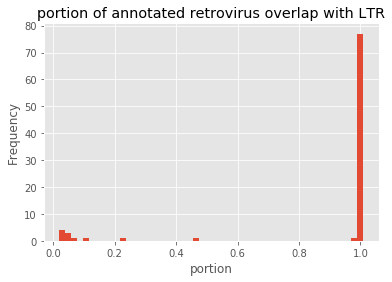

In [16]:
def get_retroviral_genes_in_LTR(ltr_fn,rna_gff_df,rna_cds_pos):
    '''
    * rna_gff_df: annotated retroviral rnas that are verified by peptides
    '''
    # get ltr bed object
    ltr_df = pd.read_csv(ltr_fn,header=None,comment='#',delim_whitespace=True,
                         names=['s_ret','e_ret','l_ret',
                    's_lLTR','e_lLTR','l_lLTR','s_rLTR','e_rLTR','l_rLTR','sim','seq_nr'])
    ltr_df['seq_nr'] = ltr_df['seq_nr'].map(lambda x: 'picr_'+str(x))
    ltr_bed = BedTool.from_dataframe(ltr_df[['seq_nr','e_lLTR','s_rLTR']])
    # transfer cds position to rna position
    rna_gff_df['cds_s']=rna_gff_df['rnaid'].map(lambda x:rna_cds_pos[x][0])
    rna_gff_df['cds_e']=rna_gff_df['rnaid'].map(lambda x:rna_cds_pos[x][1])
    rna_gff_bed = BedTool.from_dataframe(rna_gff_df[['chr','cds_s','cds_e','rnaid','geneid',
                                        'strand','gename','rna_cs','full_name']])

    rna_ltr_inter_df = rna_gff_bed.intersect(ltr_bed,wo=True).to_dataframe(
        names=['chr','s','e','rnaid','geneid','str','gename','rna_cs','full_name',
              'ltr_chr','ltr_s','ltr_e','rna_ltr_len'])

    rna_ltr_inter_df['qper'] = rna_ltr_inter_df['rna_ltr_len']/ \
                        (rna_ltr_inter_df['e']-rna_ltr_inter_df['s'])
    return rna_gff_df,rna_ltr_inter_df

ltr_fn = path + '/04_LTR_res.txt'
retro_rna_pep_gff_df,retro_rna_pep_gff_ltr_inter_df = get_retroviral_genes_in_LTR(ltr_fn,retro_rna_pep_gff_df,rna_cds_pos)
ax = retro_rna_pep_gff_ltr_inter_df['qper'].plot(kind='hist',title='portion of annotated retrovirus overlap with LTR',bins=50,align='right')
_ = ax.set_xlabel('portion')
retro_rna_pep_gff_ltr_inter_df = retro_rna_pep_gff_ltr_inter_df.query('qper==1')
anno_retro_rnas_in_ltr = retro_rna_pep_gff_ltr_inter_df['rnaid'].unique().tolist()
print 'there are',len(anno_retro_rnas_in_ltr),'annotated retroviral rnas locates between LTRs'

For sanity check, we overlap LTR with all the annotaions, see if there are other rnas location between LTR.

In [17]:
def get_non_retroviral_genes_in_LTR(ltr_fn,rna_gff_df,rna_cds_pos):
    # get ltr bed object
    ltr_df = pd.read_csv(ltr_fn,header=None,comment='#',delim_whitespace=True,
                         names=['s_ret','e_ret','l_ret',
                    's_lLTR','e_lLTR','l_lLTR','s_rLTR','e_rLTR','l_rLTR','sim','seq_nr'])
    ltr_df['seq_nr'] = ltr_df['seq_nr'].map(lambda x: 'picr_'+str(x))
    ltr_bed = BedTool.from_dataframe(ltr_df[['seq_nr','e_lLTR','s_rLTR']])
    # transfer cds position to rna position
    rna_gff_df['cds_s']=rna_gff_df['rnaid'].map(lambda x:rna_cds_pos[x][0])
    rna_gff_df['cds_e']=rna_gff_df['rnaid'].map(lambda x:rna_cds_pos[x][1])
    rna_gff_bed = BedTool.from_dataframe(rna_gff_df[['chr','cds_s','cds_e','rnaid','geneid',
                                        'strand','gename','rna_cs']])
    rna_ltr_inter_df = rna_gff_bed.intersect(ltr_bed,wo=True).to_dataframe(
        names=['chr','s','e','rnaid','geneid','str','gename','rna_cs',
              'ltr_chr','ltr_s','ltr_e','rna_ltr_len'])

    rna_ltr_inter_df['qper'] = rna_ltr_inter_df['rna_ltr_len']/ \
                        (rna_ltr_inter_df['e']-rna_ltr_inter_df['s'])
    rna_ltr_inter_df = rna_ltr_inter_df.query('qper==1')
    return rna_gff_df,rna_ltr_inter_df

noviral_rna_gff_df = noviral_rna_gff_df[noviral_rna_gff_df['rnaid'].isin(rna_cds_pos)]
noviral_rna_gff_df = noviral_rna_gff_df.reset_index(drop=True)
noviral_rna_gff_df,noviral_rna_ltr_inter_df = get_non_retroviral_genes_in_LTR(ltr_fn,noviral_rna_gff_df,rna_cds_pos)

there are 63 non retrovirus rnas overlap with LTR, they are:
['SPIN2', 'VN1R4', 'FUT3', 'IFNA12', 'LOC103160763', 'RPL32', 'LOC103160763', 'LOC103160763', 'LOC103160763', 'OR6C4', 'VN1R4', 'ALPPL2', 'IAP', 'LOC103160763', 'ELOA2', 'H2-L', 'H2-L', 'LOC103160763', 'POL_IPMAI', 'SERBP1', 'SERBP1', 'TMEM217', 'TMEM217', 'LOC103160763', 'CTSL', 'LOC103160763', 'POL_IPMAI', 'ENTPD2', 'IGHV3-6', 'OR2B2', 'MRTO4', 'SMOK2A', 'PCDHB18', 'OR51I2', 'NCR3LG1', 'UGT1A8', 'LOC103160763', 'LOC103163212', 'ZNF2', 'ZNF2', 'ZNF2', 'ZNF2', 'ZNF2', 'ZNF2', 'ZNF2', 'ZNF2', 'ZNF2', 'ZNF2', 'PRR18', 'PRR18', 'PRR18', 'PRR18', 'POL_IPMAI', 'LILRB3', 'LILRB3', 'LOC103160763', 'RPS19', 'H2B1_PONAB', 'KCNN4', 'HBA', 'OR51Q1', 'LOC103160763', 'PCDHGA4']


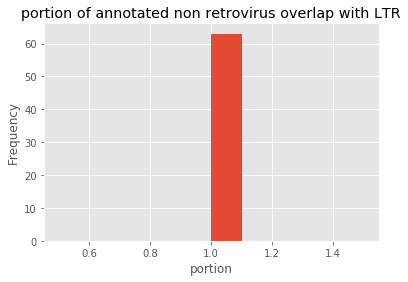

In [18]:
print 'there are',noviral_rna_ltr_inter_df.shape[0],'non retrovirus rnas overlap with LTR, they are:'
print noviral_rna_ltr_inter_df['gename'].tolist()
ax = noviral_rna_ltr_inter_df['qper'].plot(kind='hist',title='portion of annotated non retrovirus overlap with LTR')
_ = ax.set_xlabel('portion')

### Get all novel peptides
1. First we extract all novel peptides identified in proteogenomics pipeline, to achieve this, we merged all event_location.txt file from all results using cmd: ** awk 'FNR>1 || NR==1' \*/\*/event_location.txt > all_event_location.txt **
2. Then we convert all_event_location.txt to fa file. In this step, we need to remove duplications.
When virus integrate into the genome, it usually doesn't splice the fragment and insert them into different positions, this means the potential virus peptides should not be spliced. So we remove all the novel peptides that have splice sites.

In [19]:
def get_unique_event_location(event_fn,event_uniq_fn):
    '''this function get unique event location'''
    pep_dic = {}
    with open(event_fn) as inf:
        for line in inf:
            if line.startswith('#'): continue
            item = line.strip().split('\t')
            chrom,pos,pep,spec_num,loc_num,fdr,sprob,strand = item
            key = '\t'.join([chrom,pos,pep])
            if strand == '1':
                strand = '+'
            else:
                strand = '-'
            if key not in pep_dic:
                pep_dic[key] = [int(spec_num),float(fdr),float(sprob),strand]
            else:
                value = pep_dic[key]
                value[0] += int(spec_num)
                value[1] = min(value[1],float(fdr))
                value[2] = min(value[2],float(sprob))
                if value[3] != strand:
                    assert False,'strand is not consistent'
                pep_dic[key] = value
    with open(event_uniq_fn,'w') as out:
        out.write('\t'.join(['Chrom','Pos','Pep','Spec_count','FDR','Sprob','Strand'])+'\n')
        for key,value in pep_dic.iteritems():
            value = [str(v) for v in value]
            out.write(key+'\t'+'\t'.join(value)+'\n')
    # add location count column
    df = pd.read_csv(event_uniq_fn,sep='\t',header=0)
    loc_dic = df['Pep'].value_counts().to_dict()
    df['Loc_num'] = df['Pep'].map(lambda x: loc_dic[x])
    # remove spliced peptides
    df.to_csv(event_uniq_fn,sep='\t',index=False)

def remove_splice_pep(event_uniq_fn):
    '''remove peptide events that have splice sites in proteogenomics results'''
    df = pd.read_csv(event_uniq_fn,sep='\t',header=0)
    def filter_pep(pos):
        if '-' in pos: # mutation
            res = True
            frags = [f for f in pos.split(';')[:-1] if '-' not in f]
            pre = frags[0].split('/')[-1]
            for f in frags[1:]:
                pst = f.split('/')[0]
                if (int(pst)-int(pre)) != 1:
                    res = False
                    break
                pre = f.split('/')[-1]
        else:
            cds = pos.split(';')
            if len(cds) > 2:
                res = False
            else:
                res = True
        return res
    cri = df['Pos'].map(lambda x: filter_pep(x))
    df = df[cri]
    df.to_csv(event_uniq_fn,sep='\t',index=False)

In [20]:
# remove duplicate peptide event in proteogenomics results
event_fn = path + '/all_event_locations.txt'
event_uniq_fn = path + '/07_all_event_locations_uniq.txt'
if not os.path.exists(event_uniq_fn):
    get_unique_event_location(event_fn,event_uniq_fn)
    remove_splice_pep(event_uniq_fn)
    
# export unique novel peptides to a fa file. spliced peptides are removed
event_df = pd.read_csv(event_uniq_fn,sep='\t',header=0)

peps = event_df['Pep'].unique().tolist()
peps = list(set(peps).intersection(cho_novel_peps))
event_uniq_pep_fn = path + '/07_all_event_location_uniq_pep.fa'
with open(event_uniq_pep_fn,'w') as out:
    n = 1
    for pep in peps:
        out.write('>'+str(n)+'\n'+pep+'\n')
        n += 1
print 'there are', n-1, 'novel peptides,after remove the splice peptides'

there are 5104 novel peptides,after remove the splice peptides


In [21]:
event_df = event_df.query('Pep in @cho_novel_peps')
event_df = event_df.reset_index(drop=True)
event_df.to_csv(event_uniq_fn, sep='\t', index=False)

### Blast novel peptide to virus

In [22]:
# build virus database
virus_bst_prDb = path + '/virus_bst_prDb'
faFile = path + '/02_retro_virus_pr.fa'
if not os.path.exists(virus_bst_prDb):
    makeblastdb(faFile,'prot',virus_bst_prDb,'virus')
# blast to virus
pep2virus_pr_fn = path + '/08_pep2virus_pr.txt'
if not os.path.exists(pep2virus_pr_fn):
    blastp(event_uniq_pep_fn,pep2virus_pr_fn,virus_bst_prDb+'/virus',thread,mapnum=100)
    pep_index = SeqIO.index(event_uniq_pep_fn,'fasta')
    df = pd.read_csv(pep2virus_pr_fn,sep='\t',header=None)
    df[0] = df[0].map(lambda x: str(pep_index[str(x)].seq))
    df.to_csv(pep2virus_pr_fn,sep='\t',header=None,index=False)

### Analyze all results
We have 4 different mappings. 1. virus proteins mapping to picr. 2. event peptides mapping to picr. 3. LTR prediction in picr. 4. event peptide mapping to virus proteins.

In [23]:
# decide the threshold to filter virus protein mapping to picr
virus_nr2picr_fn = path + '/03_virus_pr2picr_nt.txt'
virus2picr_df = pd.read_csv(virus_nr2picr_fn,sep='\t',header=None,names=['qacc',
        'sacc','pident','length','mismatch','gapopen','qstart','qend','sstart','send',
        'evalue','bitscore','qlen','slen'])
virus2picr_df = add_strand_pst2blast(virus2picr_df)

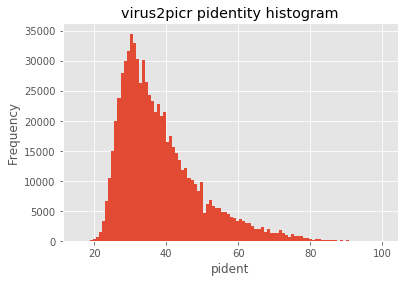

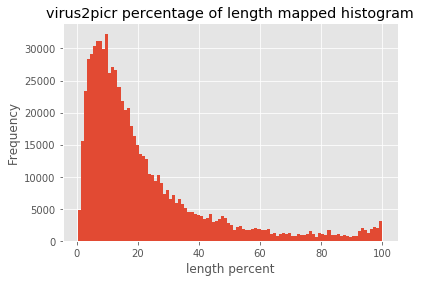

In [24]:
ax = virus2picr_df['pident'].plot(kind='hist',bins=100)
_ = ax.set_xlabel('pident')
_ = ax.set_title('virus2picr pidentity histogram')
plt.figure()      
ax = (virus2picr_df['qlen_per']*100).plot(kind='hist',bins=100)
_ = ax.set_xlabel('length percent')
_ = ax.set_title('virus2picr percentage of length mapped histogram')

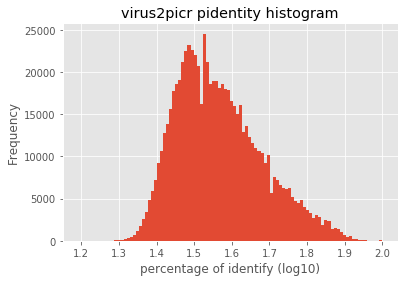

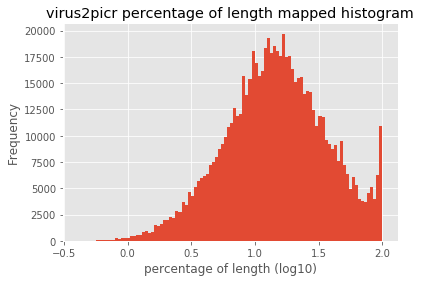

In [25]:
import numpy as np
ax = np.log10(virus2picr_df['pident']+0.01).plot(kind='hist',bins=100)
_ = ax.set_xlabel('percentage of identify (log10)')
_ = ax.set_title('virus2picr pidentity histogram')
plt.figure()
ax = np.log10(virus2picr_df['qlen_per']*100+0.01).plot(kind='hist',bins=100)
_ = ax.set_xlabel('percentage of length (log10)')
_ = ax.set_title('virus2picr percentage of length mapped histogram')

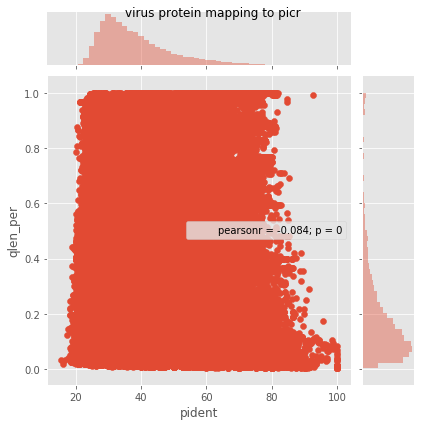

In [26]:
import seaborn as sns
ax = sns.jointplot('pident','qlen_per',virus2picr_df,kind='scatter')
_ = ax.fig.suptitle('virus protein mapping to picr')

filter virus mapping to picr and prepare dataframe for all of the 4 mapping results 

In [27]:
def event_end(pos):
    ''''''
    loc = []
    for p in pos.split(';')[:-1]:
        loc.extend([int(i) for i in p.split('/')])
    loc = [p for p in loc if p >0]
    return pd.Series([min(loc),max(loc)])

def prepare_data_from_mapping_results(virus2picr_df,event_uniq_fn,ltr_fn,pep2virus_pr_fn):
    #---------------------1. prepare virus pr to picr nt df ---------
    # filter virus pr map 2 picr genome. 
    high_virus2picr_df = virus2picr_df.query('(evalue<1e-10) & (pident>=60) & (qlen_per)>=0.60')
    high_virus2picr_df = high_virus2picr_df.reset_index(drop=True)
    virus_loc_dic = high_virus2picr_df['qacc'].value_counts().to_dict()
    #---------------------- 2. prepare proteomics event df ------------
#     event_uniq_fn = path + '/06_all_event_locations_uniq.txt'
    event_df = pd.read_csv(event_uniq_fn,sep='\t',header=0)
    event_df[['start','end']]=event_df.apply(lambda x:event_end(x['Pos']),axis=1)
    pep_loc_dic = event_df['Pep'].value_counts().to_dict()
    #---------------------- 3. prepare LTR df --------------------------
#     ltr_fn = path + '/04_LTR_res.txt'
    ltr_df = pd.read_csv(ltr_fn,header=None,comment='#',delim_whitespace=True,
                         names=['s_ret','e_ret','l_ret',
                    's_lLTR','e_lLTR','l_lLTR','s_rLTR','e_rLTR','l_rLTR','sim','seq_nr'])
    ltr_df['seq_nr'] = ltr_df['seq_nr'].map(lambda x: 'picr_'+str(x))
    #---------------------- 4. prepare peptide mapping to virus ----------
#     pep2virus_pr_fn = path + '/07_pep2virus_pr.txt'
    pep2virus_df = pd.read_csv(pep2virus_pr_fn,sep='\t',header=None,names=['qacc',
            'sacc','pident','length','mismatch','gapopen','qstart','qend','sstart','send',
            'evalue','qlen','slen'])
    pep2virus_df = add_strand_pst2blast(pep2virus_df)
    pep2virus_df = pep2virus_df.query('pident>=40 and qlen_per>=0.5')
    pep2virus_df = pep2virus_df.reset_index(drop=True)
    
    pep2virus_num = pep2virus_df['qacc'].value_counts().to_dict()
    pep2virus_df['loc_num'] = pep2virus_df['qacc'].map(lambda x: pep2virus_num[x])
    pep2virus_df = pep2virus_df.sort_values('loc_num')
    pep2virus_loc_dic = pep2virus_df.set_index('qacc')['loc_num'].to_dict()
    #---------------------- 5. prepare bedtool object --------------------
    high_virus2picr_bed = BedTool.from_dataframe(high_virus2picr_df[['sacc','start',
                                                'end','qacc','evalue','strand','pident','qlen_per']])
    event_bed = BedTool.from_dataframe(event_df[['Chrom','start','end','Pep',
                                                 'Spec_count','Strand','Loc_num','Sprob']])
    ltr_bed = BedTool.from_dataframe(ltr_df[['seq_nr','e_lLTR','s_rLTR']])
    return high_virus2picr_df,virus_loc_dic,event_df,pep_loc_dic,ltr_df,pep2virus_df,pep2virus_loc_dic,\
                high_virus2picr_bed, event_bed,ltr_bed
    
event_uniq_fn = path + '/07_all_event_locations_uniq.txt'
ltr_fn = path + '/04_LTR_res.txt'
pep2virus_pr_fn = path + '/08_pep2virus_pr.txt'
high_virus2picr_df,virus_loc_dic,event_df,pep_loc_dic,ltr_df,pep2virus_df,pep2virus_loc_dic,\
high_virus2picr_bed, event_bed,ltr_bed = prepare_data_from_mapping_results(virus2picr_df,event_uniq_fn,ltr_fn,pep2virus_pr_fn)

#### Get overlap between virus2picr and annotation
The strategy to decide a threshold to filter out the high quality virus2picr mapping is mainly using pident and qlen_per parameters:
1. start with low pident and qlen_per, in my case I started with 30% for each
2. overlap filterd virus2picr with annotation, and get overlapped gene names.
3. check non retrovirus gene names pident and parameters and get the lowest pident and qlen_per.
4. increase pident and qlen_per to the ones identified in 3. 
5. repeat step 2-4, and pay attention to the number of virus2picr mapping sites overlapped with annotated virus. Since annotation already has annotated virus, we expect the virus proteins overlape with many annotated virus, when the number of non-retrovirus genes don't decrease but the overlap with anno virus genes keeps decreasing, we stop and get the final pident and qlen_per threshold. In my test the threshold is pident>=60, qlen_per>=0.55

In [28]:
gff_df = pd.read_csv(ham_gff,sep='\t',header=None,comment='#',
                            names=['chr','source','feature','s','e','5','strand','7','anno'])
gff_df['s'] -= 1
exon_df = gff_df.query('feature == "CDS"')  # should first use exon to determine the thresholds and then use CDS here
exon_df = exon_df.reset_index(drop=True)
exon_df['rnaid'] = exon_df['anno'].map(lambda x:re.search('(?<=Parent=).+?(?=;|$)',x).group(0))
exon_df['gename'] = exon_df['anno'].map(lambda x:re.search('(?<=Name=).+?(?=;|$)',x).group(0))
exon_df['geneid'] = exon_df['anno'].map(lambda x:re.search('(?<=gene_id=).+?(?=;|$)',x).group(0))

In [29]:
exon_bed = BedTool.from_dataframe(exon_df[['chr','s','e','rnaid','gename','strand','geneid']])
virus_gff_inter_df = high_virus2picr_bed.intersect(exon_bed,wo=True,s=True).to_dataframe(
    names=['chr_virus','s_virus','e_virus','virus','evalue','str_virus','pident_virus','qlen_per',
          'anno_chr','anno_s','anno_e','rnaid','gename','strand','geneid','len'])
virus_gff_inter_df['virus_per']=virus_gff_inter_df['len']/\
                                (virus_gff_inter_df['e_virus']-virus_gff_inter_df['s_virus'])
print 'there are',virus_gff_inter_df[['chr_virus','s_virus','e_virus']].drop_duplicates().shape[0],'virus sites overlap with annoated rnas'

there are 526 virus sites overlap with annoated rnas


In [30]:
print 'high virus mapping overlap with anno rna:',len(set(virus_gff_inter_df['rnaid'].unique().tolist()).intersection(anno_viral_rnas))
print sorted(virus_gff_inter_df['gename'].unique().tolist())

high virus mapping overlap with anno rna: 127
['ENV', 'FAU', 'GAG', 'GAG-POL', 'GGAG_MLVAV', 'POL', 'V-MOS']


Since we care about the new virus sites, after getting the high quality virus2picr mapping, we need to filter out the sites that overlap with virus and non virus genes. Here we need to decide another parameter, how much overlapping with annotated genes should we filter out. The strategy is:
1. check overlap percentage with all non retrovirus genes, and get the lowest genes.
2. get the lowest percentage of virus per and use that as threshold.

In [31]:
# genames = ['EFNB2', 'ENV', 'FAU', 'GAG', 'GAG-POL', 'GAG-PRO-POL', 'GGAG_MLVAV', 'IIGP1', 'MRPS2', 'POL', 'PRO-POL', 'PTBP1', 'RABGAP1', 'RUNDC1', 'SMAD1', 'V-MOS']
genames = ['ENV', 'FAU', 'GAG', 'GAG-POL', 'GGAG_MLVAV', 'POL', 'V-MOS']
fil_virus_gff_inter_df = virus_gff_inter_df[(virus_gff_inter_df['gename'].isin(genames)) \
                        & (virus_gff_inter_df['virus_per'].values >= 0)].sort_values('gename')
fil_virus_gff_inter_df = fil_virus_gff_inter_df.reset_index(drop=True)
fil_virus_gff_inter_df['head'] = fil_virus_gff_inter_df.apply(lambda x:''.join(
                        [x['chr_virus'],str(x['s_virus']),str(x['e_virus'])]),axis=1)
fil_virus_gff_inter_genes = fil_virus_gff_inter_df['head'].unique().tolist()
print 'there are',len(fil_virus_gff_inter_genes),'virus2picr sites need to be filtered'

there are 526 virus2picr sites need to be filtered


In [32]:
# filter virus sites that overlap with annotation
high_virus2picr_df['head'] = high_virus2picr_df.apply(lambda x:':'.join(
                        [x['sacc'],str(x['start']),str(x['end'])]),axis=1)
high_virus2picr_df = high_virus2picr_df.query('head not in @fil_virus_gff_inter_genes')

### Further filter the high_virus2picr_df
1. quantify the rna level at those regions. 
2. get sites with more than 0.1 tpm

Get the nt sequence of those regions in picr that have viruses mapping to them.


In [33]:
def get_all_retro_vrial_rna_sequence(high_virus2picr_df,new_retro_viral_rna_seq_fn,ref_index):
    ''' get nt sequence of virus sites that don't have stop codons
    * high-virus2picr_df: quality filtered virus sites
    '''
    high_virus2picr_df['head']=high_virus2picr_df.apply(lambda x:':'.join([x['sacc'],str(x['start']),str(x['end']),x['strand']]),axis=1)
    new_retro_rna_sites = high_virus2picr_df['head'].unique().tolist()
    with open(new_retro_viral_rna_seq_fn,'w') as f:
        for site in new_retro_rna_sites:
            item = site.split(':')
            sqs = ref_index[item[0]].seq[int(item[1]):int(item[2])]
            if item[3] == '-':
                sqs = sqs.reverse_complement()
            if '*' not in sqs.translate():
                sqs = str(sqs)
                f.write('>'+site+'\n')
                f.write(sqs+'\n')
# get nt sequence of virus sites
new_retro_viral_rna_seq_fn = path + '/10_new_retro_viral_rna_seq.fa'
if not os.path.exists(new_retro_viral_rna_seq_fn):
    ref_index = SeqIO.index(ham_fa,'fasta')
    get_all_retro_vrial_rna_sequence(high_virus2picr_df,new_retro_viral_rna_seq_fn,ref_index)

# filter sites with stop codons
new_retro_viral_rna_seq_fn = path + '/10_new_retro_viral_rna_seq.fa'
new_virus_sites = [record.id[:-2] for record in SeqIO.parse(new_retro_viral_rna_seq_fn, 'fasta')]
high_virus2picr_df = high_virus2picr_df.query('head in @new_virus_sites')
high_virus2picr_df = high_virus2picr_df.sort_values(['sacc','sstart'])
high_virus2picr_df = high_virus2picr_df.reset_index(drop=True)

get type of raw retrovirus in annotation and novel retrovirus

In [34]:
def get_overlap_interval(df):
    '''this function overlay overlapped region and get unique unoverlapped regions'''
    intervals = {}
    for idx,row in df.iterrows():
        chrom = row['sacc']
        start = row['start']
        end   = row['send']
        virus = row['qacc'].split(',')
        if chrom not in intervals:
            intervals[chrom] = [[[start,end],virus]]
        else:
            pre = intervals[chrom][-1][0]
            if range(start,pre[-1]) == []:
                intervals[chrom].append([[start,end],virus])
            else:
                intervals[chrom][-1][0] = [min(pre[0],start),max(pre[1],end)]
                intervals[chrom][-1][1] = list(set(intervals[chrom][-1][1] + virus))
    return intervals

def add_virus_type2interval(high_virus2picr_intervals, query_index):
    # add full protein name to dictionary
    for k,v in high_virus2picr_intervals.iteritems():
        for i in range(len(v)):
            prs = [query_index[p].description for p in v[i][1]]
            v[i].append(prs)
            for pr in prs:
                if 'sarcoma' in pr or 'leukemia' in pr or 'Baboon' in pr or 'Spleen' in pr or 'Mason' in pr:
                    v[i].append('C')
                    break
                elif 'tumor' in pr:
                    v[i].append('B')
                    break
                else:
                    v[i].append('D')
        high_virus2picr_intervals[k] = v
    return high_virus2picr_intervals

query_index = SeqIO.index(query,'fasta')
high_virus2picr_intervals = get_overlap_interval(high_virus2picr_df)
high_virus2picr_intervals = add_virus_type2interval(high_virus2picr_intervals, query_index)

# virus type
typeC_num = 0
typeB_num = 0
for k,v in high_virus2picr_intervals.iteritems():
    for i in range(len(v)):
        if v[i][-1] == 'C':
            typeC_num += 1
        elif v[i][-1] == 'B':
            typeB_num +=1
retro_rna_gff_df['new_geneid'] = retro_rna_gff_df['geneid'].map(lambda x: '_'.join(x.split('_')[:2]))
print '** novel predicted retrovirus by blast\ntypeC number:',typeC_num, ', typeB number:', typeB_num
print '** annotated retrovirus\n',retro_rna_gff_df[['new_geneid','virus_type']].drop_duplicates()['virus_type'].value_counts()

** novel predicted retrovirus by blast
typeC number: 1267 , typeB number: 26
** annotated retrovirus
A    140
C    135
E     97
B     75
D     15
Name: virus_type, dtype: int64


In [35]:
def add_high_virus_type(pr):
    if 'sarcoma' in pr or 'leukemia' in pr or 'Baboon' in pr or 'Spleen' in pr or 'Mason' in pr:
        return 'C'
    elif 'tumor' in pr:
        return 'B'
    else:
        return 'D'
# add virus full name and virus type
high_virus2picr_df['full_name'] = high_virus2picr_df['qacc'].map(lambda x: query_index[x].description)
high_virus2picr_df['virus_type'] = high_virus2picr_df['full_name'].map(lambda x: add_high_virus_type(x))

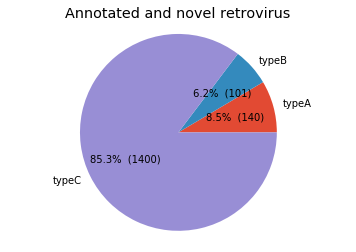

In [36]:
def make_autopct(values):
    def my_autopct(pct):
        total = sum(values)
        val = int(round(pct*total/100.0))
        return '{p:.1f}%  ({v:d})'.format(p=pct,v=val)
    return my_autopct
labels = 'typeA', 'typeB', 'typeC'
sizes = np.array([140, 101, 1400])
_ = plt.pie(sizes, labels=labels, autopct=make_autopct(sizes))
_ = plt.axis('equal')
_ = plt.title('Annotated and novel retrovirus')
plt.savefig('/data/shangzhong/anno_retro_type.svg')

Get tpm for all the annotated and novel virus sites

In [37]:
def get_expressed_retro_virus(quant_folder):
    '''
    * quant_folder has all folders of salmon results
    '''
    # merge
    folders = natsorted(glob.glob(salmon_path+'/*'))
    dfs = []
    for f in folders:
        fn = f + '/quant.sf'
        df = pd.read_csv(fn,sep='\t',header=0,usecols=[0,3],index_col=0,
                         names=['name',f.split('/')[-1]])
        dfs.append(df)
    quant_df = pd.concat(dfs,axis=1)
    return quant_df
# merge all tpm of all samples
salmon_path = path + '/quant'
quant_df = get_expressed_retro_virus(salmon_path)

cho_quant_df = quant_df.iloc[:,:45]
cho_quant_df.index = cho_quant_df.index.map(lambda x: ':'.join(x.split(':')[:-1]) if x.startswith('picr') else x)
raw_retro_viral_ids = retro_rna_gff_df['rnaid'].unique().tolist() + high_virus2picr_df['head'].unique().tolist()
cho_retro_quant_df = cho_quant_df.loc[raw_retro_viral_ids,:]
cho_retro_quant_df.to_csv(path + '/20_virus_cov_tpm.txt', sep='\t')
# get mean and median
cho_retro_quant_df['mean'] = cho_retro_quant_df.iloc[:,:45].mean(axis=1)
cho_retro_quant_df['median'] = cho_retro_quant_df.iloc[:,:45].median(axis=1)
# filter by tpm median > 0
cho_retro_quant_df = cho_retro_quant_df.query('mean > 0')
exprs_cho_retro_sites = cho_retro_quant_df.index.tolist()

In [38]:
# filter high_virus2picr_df with median tpm > 0
high_virus2picr_df = high_virus2picr_df.query('head in @exprs_cho_retro_sites')
high_virus2picr_df = high_virus2picr_df.reset_index(drop=True)
high_virus2picr_bed = BedTool.from_dataframe(high_virus2picr_df[['sacc','start',
                                                'end','qacc','evalue','strand','pident','qlen_per','virus_type']])

In [39]:
# build high quality virus intervals for each scaffold in the format 
# # {chr: [[[start,end],[pr1,pr2],[pr1 name, pr2 name], type], ...]}
high_virus2picr_intervals = get_overlap_interval(high_virus2picr_df)  
high_virus2picr_intervals = add_virus_type2interval(high_virus2picr_intervals, query_index)
# virus type
typeC_num = 0
typeB_num = 0
for k,v in high_virus2picr_intervals.iteritems():
    for i in range(len(v)):
        if v[i][-1] == 'C':
            typeC_num += 1
        elif v[i][-1] == 'B':
            typeB_num +=1
print '** novel virus sites by blast that are expressed in RNAseq level\n typeC number:',typeC_num, ', typeB number:', typeB_num
retro_rna_gff_df = retro_rna_gff_df.query('rnaid in @exprs_cho_retro_sites')
retro_rna_gff_df = retro_rna_gff_df.reset_index(drop=True)
print '** expressed annotated retrovirus:\n', retro_rna_gff_df.query('rnaid in @exprs_cho_retro_sites')\
            [['new_geneid','virus_type']].drop_duplicates()['virus_type'].value_counts()

** novel virus sites by blast that are expressed in RNAseq level
 typeC number: 799 , typeB number: 15
** expressed annotated retrovirus:
A    140
C    133
E     97
B     75
D     15
Name: virus_type, dtype: int64


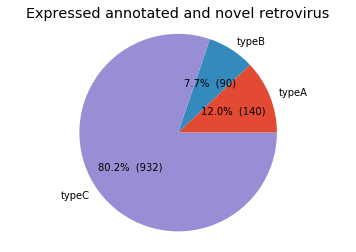

In [40]:
def make_autopct(values):
    def my_autopct(pct):
        total = sum(values)
        val = int(round(pct*total/100.0))
        return '{p:.1f}%  ({v:d})'.format(p=pct,v=val)
    return my_autopct
labels = 'typeA', 'typeB', 'typeC'
sizes = np.array([140, 90, 932])
_ = plt.pie(sizes, labels=labels, autopct=make_autopct(sizes))
_ = plt.axis('equal')
_ = plt.title('Expressed annotated and novel retrovirus')
plt.savefig('/data/shangzhong/expr_retro.svg')

#### Get overlap between virus2picr and peptide event

In [41]:
event_virus_inter_df = high_virus2picr_bed.intersect(event_bed,wo=True,s=True).to_dataframe(
    names=['chr_virus','s_virus','e_virus','virus','evalue','str_virus','pident_virus','qlen_per','virus_type',
    'chr_pep','s_pep','e_pep','pep','spec_count','str_pep','loc_num','sprob','virus_pep_len'])
event_virus_inter_df['overlap_portion'] = event_virus_inter_df['virus_pep_len']/\
                                        (event_virus_inter_df['e_pep']-event_virus_inter_df['s_pep'])

print 'the peptides which overlap with virus less than 100 percent'
display(event_virus_inter_df[['pep','overlap_portion']].drop_duplicates().query('overlap_portion<1'))
del event_virus_inter_df['overlap_portion']

the peptides which overlap with virus less than 100 percent


,pep,overlap_portion
4,RTLEGPDSSGISQAFPLR,0.166667
22,RDPPPWVRPFLPPR,0.142857
27,RDPPPWVRPFLPPR,0.571429
29,RDPPPWVRPFLPPR,0.785714
49,KNVPGPDGRPTQLPNEIDEVFPLIRPTDWDINTAAGR,0.891892
50,RLSGPCPTPLPLPAPLIPTPSAPPSTSSLLPLTEPR,0.083333
100,RRKPTPILPLEK,0.333333


In [42]:
# add virus name, description and peptide start position in virus
query_index = SeqIO.index(query,'fasta')
event_virus_inter_df['description'] = event_virus_inter_df['virus'].map(
                                    lambda x:query_index[x].description)
event_virus_inter_df['virus_loc']=event_virus_inter_df['virus'].map(lambda x: 
                                    virus_loc_dic[x])
event_virus_inter_df['pep2vir_loc'] = event_virus_inter_df['pep'].map(
    lambda x:pep2virus_loc_dic[x] if x in pep2virus_loc_dic else 0)
event_virus_inter_df['gename'] = event_virus_inter_df['virus'].map(lambda x: virus_name_dic[x])
event_virus_inter_df.to_csv(path+'/08_event_virus_inter.txt',sep='\t',index=False)

In [43]:
viruses = high_virus2picr_df['qacc'].unique().tolist()
print 'LTRharvest identifies',ltr_df.shape[0],'pairs of LTR in picr'
print 'there are',high_virus2picr_df['qacc'].unique().shape[0],'retrovirus proteins map to',\
        high_virus2picr_df[['sacc','sstart','send']].drop_duplicates().shape[0],'sites in the picr'
# print 'there are',pep2virus_df['qacc'].unique().shape[0],'novel peptides map to',\
#         pep2virus_df['sacc'].unique().shape[0],'retrovirus proteins'
print 'After getting intersection between virus and event, there are', \
        event_virus_inter_df.shape[0],'mapping results with',\
        event_virus_inter_df[['chr_virus','s_virus','e_virus']].drop_duplicates().shape[0],'sites,',\
        event_virus_inter_df['pep'].unique().shape[0],'peptides mapping to',\
        event_virus_inter_df['virus'].unique().shape[0],'viruses proteins'

LTRharvest identifies 3324 pairs of LTR in picr
there are 63 retrovirus proteins map to 2028 sites in the picr
After getting intersection between virus and event, there are 151 mapping results with 54 sites, 11 peptides mapping to 16 viruses proteins


#### Get ovralap between virus2picr and ltr

In [44]:
event_virus_inter_bed = BedTool.from_dataframe(event_virus_inter_df)
# get virus in ltr region that are supported by proteins
event_virus_ltr_inter_df = event_virus_inter_bed.intersect(ltr_bed,wo=True).to_dataframe(
    names=['chr_virus','s_virus','e_virus','virus','evalue','str_virus','pident_virus','qlen_per_virus','virus_type',
    'chr_pep','s_pep','e_pep','pep','spec_count','str_pep','loc_num','sprob','virus_pep_len',
    'description','virus_loc','pep2vir_loc','gename','ltr_chr','ltr_s','ltr_e','virus_ltr_len'])
event_virus_ltr_inter_df['virus_cov_portion'] = event_virus_ltr_inter_df['virus_ltr_len']/\
      (event_virus_ltr_inter_df['e_virus']-event_virus_ltr_inter_df['s_virus'])
# sort by ltr_chr
event_virus_ltr_inter_df.ltr_chr = event_virus_ltr_inter_df.ltr_chr.astype('category')
event_virus_ltr_inter_df.ltr_chr.cat.reorder_categories(
                natsorted(set(event_virus_ltr_inter_df.ltr_chr)),inplace=True,ordered=True)
event_virus_ltr_inter_df = event_virus_ltr_inter_df.sort_values('ltr_chr')
event_virus_ltr_inter_fn = path + '/09_event_virus_ltr_inter.txt'
event_virus_ltr_inter_df.to_csv(event_virus_ltr_inter_fn,sep='\t',index=False)
# get the virus position that are capped by LTR 
ltr_virus_df = event_virus_ltr_inter_df[['chr_virus','s_virus','e_virus','str_virus']]
ltr_virus_pos = ltr_virus_df.astype('str').apply(lambda x:':'.join(x),axis=1).tolist()

In [45]:
# get number of peptides in each ltr
pep_num_in_ltr = event_virus_ltr_inter_df[['ltr_chr','ltr_s','ltr_e','pep']]\
        .drop_duplicates().groupby(['ltr_chr','ltr_s','ltr_e']).size().reset_index(name='number of unique peptides')
ltr_num_with_virus_pep = event_virus_ltr_inter_df[['ltr_chr','ltr_s','ltr_e']].drop_duplicates().shape[0]
print 'there are',len(ltr_virus_pos),'virus sites in ltr region'
print 'there are',ltr_num_with_virus_pep,'ltrs have peptide supported virus'
print 'there are',event_virus_ltr_inter_df['virus'].unique().shape[0],'virus proteins in ltrs'
print 'there are',event_virus_ltr_inter_df[['chr_virus','s_virus','e_virus']].drop_duplicates().shape[0],\
        'virus sites inside LTR that have peptides supporting them'
display(pep_num_in_ltr)

there are 19 virus sites in ltr region
there are 1 ltrs have peptide supported virus
there are 8 virus proteins in ltrs
there are 6 virus sites inside LTR that have peptides supporting them


,ltr_chr,ltr_s,ltr_e,number of unique peptides
0,picr_180,488031,495889,5


In [46]:
print 'After intersection among event,peptides and LTR, there are',\
    event_virus_ltr_inter_df.shape[0],'mapping results and',\
    event_virus_ltr_inter_df[['ltr_chr','ltr_s','ltr_e']].drop_duplicates().shape[0],\
    'unique LTRs'

After intersection among event,peptides and LTR, there are 19 mapping results and 1 unique LTRs


In [47]:
virus_prs_map2picr = high_virus2picr_df['qacc'].unique().tolist()
peptide_supported_virus_prs=event_virus_inter_df['virus'].unique().tolist()
ltr_wrapped_virus_prs=event_virus_ltr_inter_df['virus'].unique().tolist()

In [48]:
print 'there are',len(virus_prs_map2picr),'virus proteins map to picr are: ',','.join(virus_prs_map2picr)
print 'there are',len(peptide_supported_virus_prs),'peptide supported virus proteins are:',','.join(peptide_supported_virus_prs)
print 'there are',len(ltr_wrapped_virus_prs),'ltr surrounded virus proteins are:',','.join(ltr_wrapped_virus_prs)

there are 63 virus proteins map to picr are:  NP_056790.1,YP_009109692.1,NP_040333.1,NP_955579.1,NP_955592.1,NP_955580.1,NP_043519.1,YP_004680224.1,YP_009243644.1,NP_955582.1,NP_955589.1,NP_598370.1,NP_598373.1,NP_955578.1,NP_955588.2,YP_001165469.3,NP_056789.1,NP_955527.1,NP_955585.1,NP_955597.1,NP_955572.1,NP_955526.1,NP_955583.1,NP_955593.1,NP_955596.1,YP_001165470.1,NP_955590.1,YP_009109693.1,NP_955574.1,YP_009109698.1,YP_009109696.1,NP_955576.1,NP_040332.1,NP_043518.1,NP_057934.1,NP_057858.1,NP_955591.1,YP_009109694.1,NP_955577.1,NP_954561.1,NP_047256.1,NP_057933.2,YP_001497148.1,YP_009109689.1,NP_955586.1,YP_004680223.1,YP_009109695.1,NP_955563.1,NP_041217.1,YP_001165472.1,NP_955569.1,NP_579906.1,NP_057859.1,NP_955529.1,YP_008169843.1,NP_040334.1,NP_057935.1,NP_598374.1,YP_009243643.1,NP_047255.1,NP_955565.1,NP_954557.1,NP_598371.2
there are 16 peptide supported virus proteins are: YP_009109696.1,NP_955527.1,NP_955574.1,NP_955585.1,YP_009109698.1,NP_955576.1,NP_955526.1,NP_955583

In [49]:
# expressed high quality virus sites overlap with ltr
new_retro_rna_ltr_df = high_virus2picr_bed.intersect(ltr_bed,wo=True).to_dataframe(
    names=['chr_virus','s_virus','e_virus','virus','evalue','str_virus','pident_virus','qlen_per_virus','virus_type',
           'ltr_chr','ltr_s','ltr_e','virus_ltr_len'])
new_retro_rna_ltr_df['perc_len'] = new_retro_rna_ltr_df['virus_ltr_len']/(new_retro_rna_ltr_df['e_virus']-new_retro_rna_ltr_df['s_virus'])
new_retro_rna_ltr_df['head'] = new_retro_rna_ltr_df.apply(lambda x:':'.join([x['chr_virus'],str(x['s_virus']),str(x['e_virus']),x['str_virus']]),axis=1)

new_retro_rna_ltr_sites = new_retro_rna_ltr_df['head'].unique().tolist()

In [50]:
new_retro_rna_sites = []
for record in SeqIO.parse(new_retro_viral_rna_seq_fn,'fasta'):
    new_retro_rna_sites.append(record.id)
new_retro_rna_pep_sites = event_virus_inter_df.apply(lambda x:':'.join([x['chr_virus'],
                str(x['s_virus']),str(x['e_virus']),x['str_virus']]),axis=1).unique().tolist()
# sequence header of viruses that map to LTR with peptides supporting the mapping
new_retro_rna_ltr_pep_sites = event_virus_ltr_inter_df.apply(lambda x:':'.join([x['chr_virus'],
                str(x['s_virus']),str(x['e_virus']),x['str_virus']]),axis=1).unique().tolist()

#### After getting all the results, we store the confident results into a gff file.
1. The annotated retrovirus supported by peptides can be directly extracted from reference gff file
2. Generate LTR surrounded peptide supported virus gff by parsing the overlapping results
3. Generate non-LTR surrounded peptide supprted virus gff by parsing 08_event_virus_inter.txt

In [51]:
# # 1. get annotated retrovirus gff3 file
# def get_retro_anno_gff(ham_gff,virus_gff,retro_anno_rnas):
#     ''' This function extracts rnas that are annotated as retrovirus
#     * retro_anno_rnas: retro virus in annotation file
#     '''
#     with open(ham_gff) as f, open(virus_gff,'w') as out:
#         pre_gene = ''
#         rnaid = ''
#         for line in f:
#             if line.startswith('#'):continue
#             item = line.strip().split('\t')
#             if item[2] == 'gene':
#                 gene = line
#             elif item[2] == 'mRNA':
#                 rnaid = re.search('(?<=ID=).+?(?=;)',item[8]).group(0)
#             elif item[2] in ['exon','CDS']:
#                 rnaid = re.search('(?<=Parent=).+?(?=;)',item[8]).group(0)
#             if rnaid in retro_anno_rnas:
#                 if gene != pre_gene:
#                     out.write(gene)
#                     pre_gene = gene
#                 out.write(line)
                
# anno_retro_virus_gff = path + '/11_anno_retro_virus.gff3'
# if not os.path.exists(anno_retro_virus_gff):
#     get_retro_anno_gff(ham_gff,anno_retro_virus_gff,anno_viral_rnas_with_pep)

# # 2. get build {LTR:[[s,e,str],{pr:[s,e,str]}]}
# def build_ltr_gff(event_virus_ltr_inter_fn,ltr_virus_gff):
#     '''this functions transfers ltr supported virus to gff format'''
#     ltr_virus_gff_dic = {}
#     ltr_index = 0
#     pre_ltr = ''
#     with open(event_virus_ltr_inter_fn) as f:
#         n = 0
#         for line in f:
#             n += 1
#             if n == 1:
#                 continue
#             item = line.strip().split('\t')
#             ltr_chr,ltr_s,ltr_e = item[20:23]
#             ltr = ':'.join(item[20:23])
#             virus =  item[:4]+[item[5],item[19]]
#             if ltr != pre_ltr:
#                 ltr_index += 1
#                 ltr_id = 'LTR_'+ str(ltr_index)
#                 pre_ltr = ltr
#             if ltr_id not in ltr_virus_gff_dic:
#                 ltr_virus_gff_dic[ltr_id] = [item[20:23],virus]
#             else:
#                 if virus not in ltr_virus_gff_dic[ltr_id]:
#                     ltr_virus_gff_dic[ltr_id].append(virus)
#     # output files
#     with open(ltr_virus_gff,'w') as out:
#         for key in natsorted(ltr_virus_gff_dic.keys()):
#             value = ltr_virus_gff_dic[key]
#             v = value[0]
#             out.write('\t'.join([v[0],'ltr','gene',v[1],v[2],'.','.','.','ID='+key])+'\n')
#             for v in value[1:]:
#                 anno = 'ID={rna};Parent={ltrid};Name={gename}'.format(rna=v[3],ltrid=key,
#                                                                      gename=v[5])
#                 out.write('\t'.join([v[0],'ltr','mRNA',v[1],v[2],'.',v[4],'.',anno])+'\n')
#                 out.write('\t'.join([v[0],'ltr','CDS',v[1],v[2],'.',v[4],'.',anno])+'\n')
#     return ltr_virus_gff_dic
# ltr_virus_gff = path + '/11_ltr_virus.gff3'
# ltr_virus_gff_dic = build_ltr_gff(event_virus_ltr_inter_fn,ltr_virus_gff)
# for k,v in ltr_virus_gff_dic.iteritems():
#     ltr_virus_gff_dic[k] = [v[0],list(set([n[5] for n in v[1:]]))]
# ltr_virus_gff_dic

# # 3. get non ltr virus gff file
# # filter out ltr supported viruses
# def get_non_ltr_virus_gff(event_virus_ltr_inter_fn,event_virus_inter_gff_fn):
#     event_virus_ltr_inter_df = pd.read_csv(event_virus_ltr_inter_fn,header=0,sep='\t')
#     ltr_viruses = event_virus_ltr_inter_df[['chr_virus','s_virus','e_virus','str_virus']].apply(
#                                     lambda x: ':'.join([str(p) for p in x]),axis=1).tolist()
#     event_virus_inter_fn = path+'/08_event_virus_inter.txt'
#     event_virus_inter_df = pd.read_csv(event_virus_inter_fn,sep='\t',header=0)
#     event_virus_inter_df['id'] = event_virus_inter_df[
#                                     ['chr_virus','s_virus','e_virus','str_virus']].apply(
#                                     lambda x: ':'.join([str(p) for p in x]),axis=1).tolist()
#     event_virus_inter_df = event_virus_inter_df[~event_virus_inter_df['id'].isin(ltr_viruses)]
#     # output results
    
#     inter_df=event_virus_inter_df[['chr_virus','s_virus','e_virus','str_virus','virus','gename']]
#     inter_df = inter_df.drop_duplicates()
#     inter_df = inter_df.reset_index(drop=True)
#     inter_df.chr_virus = inter_df.chr_virus.astype('category')
#     inter_df.chr_virus.cat.reorder_categories(natsorted(set(inter_df.chr_virus)),inplace=True,ordered=True)
#     inter_df.to_csv(event_virus_inter_gff_fn,sep='\t',index=False)
# event_virus_ltr_inter_fn = path + '/09_event_virus_ltr_inter.txt'
# event_virus_inter_gff_fn = path + '/11_event_virus_inter.gff'
# if not os.path.exists(event_virus_inter_gff_fn):
#     get_non_ltr_virus_gff(event_virus_ltr_inter_fn,event_virus_inter_gff_fn)

### Use CHOS pacbio to detect retrovirus
Strategies would be: 
1. tblastn virus proteins to CHOS pacbio reads.
2. tblastn new event peptides to CHOS pacbio reads.
3. get overlap between 1-2.
4. extract the mapped virus sequence in pacbio reads.
5. repeat step 1-3 for hamster pacbio reads
6. blast 4 to hamster pacbio reads that don't map to picr
7. In 5 results remove those that exist in 7
8. blast 4 to picr.
9. Map pacbio reads to picr genome to decide the location that are surrounded by LTR.

##### 1. tblastn virus peptides to CHOS pacbio reads
##### 2. tblastn peptide to CHOS pacbio reads

In [52]:
pep_query = path + '/07_all_event_location_uniq_pep.fa'
virus_query = path + '/02_retro_virus_pr.fa'
pep2chos_pacbio = path + '/12_novelpep2chospacbio.txt'
virus2chos_pacbio = path + '/12_virus2chospacbio.txt'
database = '/data/shangzhong/Pacbio/correct_chos_pacbio_blast_db/pacbio'
chos_pacbio = '/data/shangzhong/Pacbio/correct.fa.gz'
if not os.path.exists(os.path.dirname(database)):
    os.mkdir(os.path.dirname(database))
    makeblastdb(chos_pacbio,'nucl',os.path.dirname(database),os.path.basename(database))
if not os.path.exists(pep2chos_pacbio):
    tblastn(pep_query,pep2chos_pacbio,database,thread)
if not os.path.exists(virus2chos_pacbio):
    query = path + '/02_retro_virus_pr.fa'
    tblastn(virus_query,virus2chos_pacbio,database,thread)

##### 3. Get overlap between virus mapping and peptide mapping

In [53]:
# read virus map 2 pacbio
virus2pacbio_fn = path + '/12_virus2chospacbio.txt'
virus2pacbio_df = pd.read_csv(virus2pacbio_fn,sep='\t',header=None,names=['qacc',
        'sacc','pident','length','mismatch','gapopen','qstart','qend','sstart','send',
        'evalue','qlen','slen'])
virus2pacbio_df = add_strand_pst2blast(virus2pacbio_df)
virus2pacbio_df = virus2pacbio_df.query('pident>=60 and qlen_per>=0.55')
virus2pacbio_df = virus2pacbio_df.reset_index(drop=True)
virus2pacbio_bed = BedTool.from_dataframe(virus2pacbio_df[['sacc','start',
                                            'end','qacc','evalue','strand','pident','slen']])
virus2pacbio_loc_dic = virus2pacbio_df['qacc'].value_counts().to_dict()

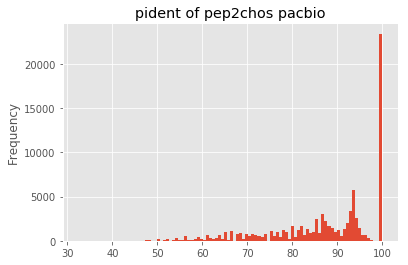

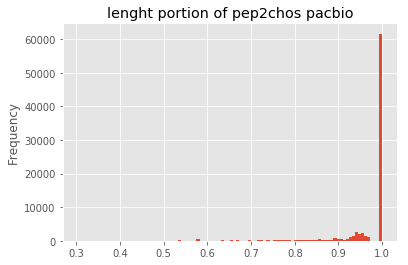

In [54]:
# read peptide map 2 pacbio
pep2pacbio_fn = path + '/12_novelpep2chospacbio.txt'
pep2pacbio_df = pd.read_csv(pep2pacbio_fn,sep='\t',header=None,names=['qacc',
        'sacc','pident','length','mismatch','gapopen','qstart','qend','sstart','send',
        'evalue', 'bitscore', 'qlen','slen'])
pep2pacbio_df = add_strand_pst2blast(pep2pacbio_df)
ax = pep2pacbio_df['pident'].plot(kind='hist',bins=100)
_ = ax.set_title('pident of pep2chos pacbio')
plt.figure()
ax = pep2pacbio_df['qlen_per'].plot(kind='hist',bins=100)
_ = ax.set_title('lenght portion of pep2chos pacbio')

In [55]:
# should conisder perfect mapping peptides
pep2pacbio_df = pep2pacbio_df.query('pident==100 and qlen_per==1')
pep2pacbio_df = pep2pacbio_df.reset_index(drop=True)
pep2pacbio_bed = BedTool.from_dataframe(pep2pacbio_df[['sacc','start',
                                            'end','qacc','evalue','strand','pident']])
pep2pacbio_loc_dic = pep2pacbio_df['qacc'].value_counts().to_dict()
# get overlap
pac_virus_pep_inter_df = virus2pacbio_bed.intersect(pep2pacbio_bed,wo=True,s=True).to_dataframe(
                names=['chr','v_s','v_e','virus','virus_evalue','v_str','v_pident','v_slen','pac_chr',
                'p_s','p_e','p_id','p_value','p_str','p_ident','length'])
pac_virus_pep_inter_df['head'] = pac_virus_pep_inter_df.apply(lambda x:':'.join([x['chr'],str(x['v_s']),str(x['v_e'])]),axis=1)

In [56]:
print 'there are',virus2pacbio_df['qacc'].unique().shape[0],'virus proteins map to CHOS pacbio'
print 'there are',pac_virus_pep_inter_df['virus'].unique().shape[0],'virus map to CHOS pacbio with peptide support'
print 'there are',pac_virus_pep_inter_df['p_id'].unique().shape[0],'peptides support virus map to CHOS pacbio'

there are 76 virus proteins map to CHOS pacbio
there are 14 virus map to CHOS pacbio with peptide support
there are 5 peptides support virus map to CHOS pacbio


##### 4. extract CHOS virus mapped sequence that have peptides support

In [57]:
import gzip
def extract_fa_reads(gzfa,ids,out_fn):
    '''this function extracts reads from the zipped fasta file'''
    with gzip.open(gzfa,'rt') as f, open(out_fn,'w') as out:
        for record in SeqIO.parse(f,'fasta'):
            if record.id in ids:
                SeqIO.write(record,out,'fasta')
# get full CHOS pacbio reads that have peptide and virus mapping to them
# this reads the whole pacbio fa file, therefore it takes a long time.
chos_pb_reads_with_virus_pep_fn = path + '/14_chos_pacbio_read_with_virus_pep.fa'
chos_pb_reads_with_virus_pep_ids = pac_virus_pep_inter_df['chr'].unique().tolist()
if not os.path.exists(chos_pb_reads_with_virus_pep_fn):
    extract_fa_reads(chos_pacbio,chos_pb_reads_with_virus_pep_ids,chos_pb_reads_with_virus_pep_fn)

In [58]:
# get virus sites in CHOS pacbio reads that have peptides support
chos_pb_virus_sites_fn = path + '/15_chos_pacbio_virus_sites.fa'
if not os.path.exists(chos_pb_virus_sites_fn):
    chos_pb_index = SeqIO.index(chos_pb_reads_with_virus_pep_fn,'fasta')
    with open(chos_pb_virus_sites_fn,'w') as out:
        for index, row in pac_virus_pep_inter_df[['chr','v_s','v_e']].drop_duplicates().iterrows():
            start = row['v_s']
            end = row['v_e']
            chrom = row['chr']
            head = ':'.join([chrom,str(start),str(end)])
            seq = chos_pb_index[row['chr']].seq[start:end]
            out.write('>'+head+'\n'+str(seq)+'\n')
# blast CHOS pacbio virus sites that have peptides support to picr
chos_pb_virus_sites2picr_fn = path + '/16_chos_pb_virus_sites2picr.txt'
if not os.path.exists(chos_pb_virus_sites2picr_fn):
    blastn(chos_pb_virus_sites_fn, chos_pb_virus_sites2picr_fn, ham_blastdb, thread, 1000)

##### 5. repeat step 1-4 for hamster pacbio reads

In [59]:
hamster_pacbio = '/data/shangzhong/Pacbio/hamster_pacbio/hamster_pacbio_correct.fa.gz'
database = '/data/shangzhong/Pacbio/correct_hamster_pacbio_blast_db/pacbio'
pep2hamster_pacbio = path + '/13_novelpep2hamsterpacbio.txt'
virus2hamster_pacbio = path + '/13_virus2hamsterpacbio.txt'
if not os.path.exists(os.path.dirname(database)):
    os.mkdir(os.path.dirname(database))
    makeblastdb(hamster_pacbio,'nucl',os.path.dirname(database),os.path.basename(database))
if not os.path.exists(pep2hamster_pacbio):
    tblastn(pep_query,pep2hamster_pacbio,database,thread)
if not os.path.exists(virus2hamster_pacbio):
    tblastn(virus_query,virus2hamster_pacbio,database,thread)

In [60]:
# read in virus mapping to hamster pacbio sites
virus2ham_pb_df = pd.read_csv(virus2hamster_pacbio,sep='\t',header=None,names=['qacc',
        'sacc','pident','length','mismatch','gapopen','qstart','qend','sstart','send',
        'evalue','qlen','slen'])
virus2ham_pb_df = add_strand_pst2blast(virus2ham_pb_df)
virus2ham_pb_df = virus2ham_pb_df.query('pident>=60 and qlen_per>=0.8')
virus2ham_pb_df = virus2ham_pb_df.reset_index(drop=True)
# read in peptide mapping
pep2ham_pb_df = pd.read_csv(pep2hamster_pacbio,sep='\t',header=None,names=['qacc',
        'sacc','pident','length','mismatch','gapopen','qstart','qend','sstart','send',
        'evalue','bitscore','qlen','slen'])
pep2ham_pb_df = add_strand_pst2blast(pep2ham_pb_df)
pep2ham_pb_df = pep2ham_pb_df.query('pident==100 and qlen_per==1')
pep2ham_pb_df = pep2ham_pb_df.reset_index(drop=True)
# prepare bed frame
virus2ham_pb_bed = BedTool.from_dataframe(virus2ham_pb_df[['sacc','start','end',
                                                'qacc','evalue','strand','pident','slen']])
pep2ham_pb_bed = BedTool.from_dataframe(pep2ham_pb_df[['sacc','start','end',
                                                'qacc','evalue','strand','pident']])
# get overlap between virus and peptide mapping to hamster pacbio
ham_pac_virus_pep_inter_df = virus2ham_pb_bed.intersect(pep2ham_pb_bed,wo=True,s=True).to_dataframe(
                names=['chr','v_s','v_e','virus','virus_evalue','v_str','v_pident','v_slen','pac_chr',
                'p_s','p_e','p_id','p_value','p_str','p_ident','length'])

In [61]:
print 'results on mapping to hamster pacbio reads:'
print 'there are',virus2ham_pb_df['qacc'].unique().shape[0],'virus proteins map to hamster pacbio'
print 'there are',ham_pac_virus_pep_inter_df['virus'].unique().shape[0],'virus map to hamster pacbio with peptide support'
print 'there are',ham_pac_virus_pep_inter_df['p_id'].unique().shape[0],'peptides support virus map to hamster pacbio'

results on mapping to hamster pacbio reads:
there are 45 virus proteins map to hamster pacbio
there are 8 virus map to hamster pacbio with peptide support
there are 5 peptides support virus map to hamster pacbio


##### 6. blast CHOS virus sites to hamster pacbio reads

In [62]:
# blast CHOS virus sites to hamster pacbio reads
chos_virus2ham_pb_fn = path + '/17_chos_pacbio_virus_sites_with_pep2hamster_pacbio.txt'
if not os.path.exists(chos_virus2ham_pb_fn):
    blastn(chos_pb_virus_sites_fn,chos_virus2ham_pb_fn,database,thread,250)

##### 7. In CHOS pacbio virus results remove those that exist in hamster pacbio virus results

In [63]:
# build {chos pacbio virus sites: [[virus protein,peptide id]]}
chos_pb_viruspr_dic = {}
for idx,row in pac_virus_pep_inter_df.iterrows():
    key = ':'.join([row['chr'],str(row['v_s']),str(row['v_e'])])
    if key in chos_pb_viruspr_dic:
        chos_pb_viruspr_dic[key].append([row['virus'],row['p_id']])
    else:
        chos_pb_viruspr_dic[key] = [[row['virus'],row['p_id']]]
# build {hamster pacbio virus sites: [[virus protein,peptide]]}
ham_pb_viruspr_dic = {}
for idx,row in ham_pac_virus_pep_inter_df.iterrows():
    key = row['chr']
    if key in ham_pb_viruspr_dic:
        ham_pb_viruspr_dic[key].append([row['virus'],row['p_id']])
    else:
        ham_pb_viruspr_dic[key] = [[row['virus'],row['p_id']]]

In [64]:
# reads in chos pb virus sites
chos_pb_reads_with_virus_pep_sites_dic = SeqIO.index(chos_pb_virus_sites_fn,'fasta')
chos_pb_reads_with_virus_pep_sites = list(chos_pb_reads_with_virus_pep_sites_dic.keys())

In [65]:
# read chos virus sites mapping to hamster pacbio reads
chos_virus2ham_pb_df = pd.read_csv(chos_virus2ham_pb_fn,sep='\t',header=None,names=['qacc',
        'sacc','pident','length','mismatch','gapopen','qstart','qend','sstart','send',
        'evalue','bitscore','qlen','slen'])
chos_virus2ham_pb_df = add_strand_pst2blast(chos_virus2ham_pb_df)

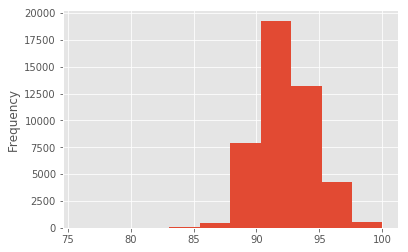

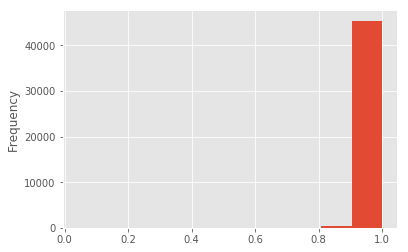

In [66]:
ax = chos_virus2ham_pb_df['pident'].plot(kind='hist')
plt.figure()
ax = chos_virus2ham_pb_df['qlen_per'].plot(kind='hist')

In [67]:
chos_virus2ham_pb_df = chos_virus2ham_pb_df.query('qlen_per >= 0.8')
chos_virus2ham_pb_df = chos_virus2ham_pb_df.reset_index(drop=True)

In [68]:
# build {chos virus sites:hamster pacbio reads}
chos_virus2ham_pb_dic = {k:list(v) for k,v in chos_virus2ham_pb_df.groupby('qacc')['sacc']}

In [69]:
# find CHOS virus sites that should be removed because they also exist in hamster
rm_chos_virus_sites = []
for k,v in chos_virus2ham_pb_dic.iteritems():
    chos_v_p = chos_pb_viruspr_dic[k]
    ham_v_p = []
    for hamv in v:
        if hamv in ham_pb_viruspr_dic:
            ham_v_p.extend(ham_pb_viruspr_dic[hamv])
    keep = [s in ham_v_p for s in chos_v_p]
    if True in keep:
        rm_chos_virus_sites.append(k)
print 'there are',pac_virus_pep_inter_df['head'].unique().shape[0],'chos virus sites in total'
print 'among them,',len(rm_chos_virus_sites),'are filtered by hamster pacbio reads'

there are 182 chos virus sites in total
among them, 151 are filtered by hamster pacbio reads


In [70]:
keep_pac_virus_pep_inter_df = pac_virus_pep_inter_df.query('head not in @rm_chos_virus_sites')
keep_pac_virus_pep_inter_df = keep_pac_virus_pep_inter_df.reset_index(drop=True)
keep_chos_virus_sites = keep_pac_virus_pep_inter_df['head'].unique().tolist()
print 'there are',len(keep_chos_virus_sites),'sites needs to be further studied'

there are 31 sites needs to be further studied


##### 8. after filtering CHOS virus sites, then we map them to picr to see if they map to new sites
for chos pacbio virus sites with peptides, remove those map to hamster pacbio reads, then remove those map to picr. the reason we filter both, is that the hamster pacbio read may have some additional sequence that are not included in the picr genome.

In [71]:
# get overlap between CHOS pacbio virus sites in picr and hamster virus sites with peptides support
chos_pb_virus_sites2picr_df = pd.read_csv(chos_pb_virus_sites2picr_fn,sep='\t',header=None,names=['qacc',
        'sacc','pident','length','mismatch','gapopen','qstart','qend','sstart','send',
        'evalue', 'bitscore', 'qlen','slen'])
chos_pb_virus_sites2picr_df = chos_pb_virus_sites2picr_df.query('qacc in @keep_chos_virus_sites')
chos_pb_virus_sites2picr_df = add_strand_pst2blast(chos_pb_virus_sites2picr_df)
chos_pb_virus_sites2picr_df = chos_pb_virus_sites2picr_df.query('qlen_per>0.8')
chos_pb_virus_sites2picr_df = chos_pb_virus_sites2picr_df.reset_index(drop=True)
chos_pb_virus_sites2picr_df['head'] = chos_pb_virus_sites2picr_df.apply(lambda 
                        x:':'.join([x['sacc'],str(x['start']),str(x['end'])]),axis=1)
chos_pb_virus_sites2picr_bed = BedTool.from_dataframe(chos_pb_virus_sites2picr_df[['sacc',
                                        'start','end']].drop_duplicates())
ham_virus_sites_bed = BedTool.from_dataframe(high_virus2picr_df[['sacc','start','end']].drop_duplicates())
# ham_virus_sites_bed = BedTool.from_dataframe(event_virus_inter_df[['chr_virus','s_virus','e_virus']].drop_duplicates())
chos_pb_virus_ham_df = chos_pb_virus_sites2picr_bed.intersect(ham_virus_sites_bed,wao=True).to_dataframe(names=[
    'pb_chr','p_s','p_e','chr','start','end','len'])
chos_pb_virus_ham_df['p_per'] = chos_pb_virus_ham_df['len']/(chos_pb_virus_ham_df['p_e']-chos_pb_virus_ham_df['p_s'])
chos_pb_virus_ham_df['per'] = chos_pb_virus_ham_df['len']/(chos_pb_virus_ham_df['end']-chos_pb_virus_ham_df['start'])
chos_pb_virus_ham_df['head']=chos_pb_virus_ham_df.apply(lambda x:':'.join([x['pb_chr'],str(x['p_s']),str(x['p_e'])]),axis=1)
chos_only_virus_sites = set(keep_chos_virus_sites)-set(chos_pb_virus_sites2picr_df['qacc'].unique().tolist())
print 'After blasting CHOS pacbio virus sites which have peptide supports to picr,',\
    chos_pb_virus_sites2picr_df[['sacc','start','end']].drop_duplicates().shape[0],\
    'virus sites are detected,but keep in mind they overlap with each other'
print 'there are',len(keep_chos_virus_sites)-chos_pb_virus_sites2picr_df['qacc'].unique().shape[0],\
    'chos virus sites that do not map to picr'

After blasting CHOS pacbio virus sites which have peptide supports to picr, 709 virus sites are detected,but keep in mind they overlap with each other
there are 0 chos virus sites that do not map to picr


In [72]:
chos_pb_virus_sites2picr_df.head()

,qacc,sacc,pident,length,mismatch,gapopen,qstart,qend,sstart,send,evalue,bitscore,qlen,slen,qlen_per,start,end,strand,head
0,m151219_095815_42149_c100932032550000001823209...,picr_63,98.428,318,5,0,0,318,3341254,3341571,1.150000e-157,560.0,318,12151076,1.0,3341253,3341571,+,picr_63:3341253:3341571
1,m151219_095815_42149_c100932032550000001823209...,picr_126,98.113,318,6,0,0,318,1521722,1522039,5.360000e-156,555.0,318,3919131,1.0,1521721,1522039,+,picr_126:1521721:1522039
2,m151219_095815_42149_c100932032550000001823209...,picr_71,98.113,318,6,0,0,318,10705365,10705048,5.360000e-156,555.0,318,11002660,1.0,10705047,10705365,-,picr_71:10705047:10705365
3,m151219_095815_42149_c100932032550000001823209...,picr_51,98.113,318,6,0,0,318,11474926,11474609,5.360000e-156,555.0,318,14304651,1.0,11474608,11474926,-,picr_51:11474608:11474926
4,m151219_095815_42149_c100932032550000001823209...,picr_38,98.113,318,6,0,0,318,6921141,6921458,5.360000e-156,555.0,318,18231711,1.0,6921140,6921458,+,picr_38:6921140:6921458


In [73]:
pac_virus_pep_inter_df.query('head in @chos_only_virus_sites')

,chr,v_s,v_e,virus,virus_evalue,v_str,v_pident,v_slen,pac_chr,p_s,p_e,p_id,p_value,p_str,p_ident,length,head


In [74]:
# build {virus sites in picr: virus sites in CHOS pacbio}
picr_chos_pb_virus_sites_dic = {k:list(v) for k,v in chos_pb_virus_sites2picr_df[['head','qacc']]\
                                .drop_duplicates().groupby('head')['qacc']}

The reason why virus sites supported by CHOS pacbio reads is more than the hamster virus sites is because the CHOS pacbio reads overlap with each other and map to regions that are overlapped.

In [75]:
# split CHOS pacbio reads mapping results to picr to two categories, 1. overlap wiht virus sites in viruspr2picr
# 2. don't overlap with virus sites
# chos_pb_virus_ham_df is chos_pb_virus2picr overlap with high quality virus sites 2 picr.
new_chos_pb_virus_df = chos_pb_virus_ham_df.query('per != per') # map to novel sites 
picr_chos_pb_virus_df = chos_pb_virus_ham_df.query('per == per')
picr_chos_pb_virus_df = picr_chos_pb_virus_df.reset_index(drop=True) # chos pacbio virus sites overlap with hamster virus sites
known_picr_chos_pb_virus_sites = picr_chos_pb_virus_df.query('p_per > 0.4')['head'].tolist()
new_picr_chos_pb_virus_sites = picr_chos_pb_virus_df.query('p_per < 0.4')['head'].tolist()
new_picr_chos_pb_virus_sites = list(set(new_picr_chos_pb_virus_sites)-set(known_picr_chos_pb_virus_sites))
new_picr_chos_pb_virus_df = picr_chos_pb_virus_df.query('head in @new_picr_chos_pb_virus_sites')
new_picr_chos_pb_virus_df = new_picr_chos_pb_virus_df.reset_index(drop=True)
print 'there are',new_chos_pb_virus_df[['pb_chr','p_s','p_e']].drop_duplicates().shape[0],\
        'picr sites with CHOS pacbio mappped but do not have overlapping virus sites'
print 'there are',picr_chos_pb_virus_df[['pb_chr','p_s','p_e']].drop_duplicates().shape[0],\
        'picr sites with CHOS pacbio mapped and have overlapping virus sites,among them, we need to',\
        'check',len(new_picr_chos_pb_virus_sites),'sites with low overlap'

there are 330 picr sites with CHOS pacbio mappped but do not have overlapping virus sites
there are 379 picr sites with CHOS pacbio mapped and have overlapping virus sites,among them, we need to check 89 sites with low overlap


In [76]:
def get_virus_pep(chos_pb_read,chos_pb_viruspr_dic):
    ''''''
    reads = chos_pb_read.split(';')
    virus = []
    pep = []
    for read in reads:
        virus_pep = chos_pb_viruspr_dic[read]
        virus.extend([v[0] for v in virus_pep])
        pep.extend([str(v[1]) for v in virus_pep])
    return [','.join(list(set(virus))),','.join(list(set(pep)))]

In [77]:
# merge the two categories of new virus sites in 2 cells above
merge_new_sites_df = new_chos_pb_virus_df[['pb_chr','p_s','p_e','head']].append(
        new_picr_chos_pb_virus_df[['pb_chr','p_s','p_e','head']])
merge_new_sites_df = merge_new_sites_df.sort_values(['pb_chr','p_s'])
merge_new_sites_df['chos_pb_read'] = merge_new_sites_df['head'].map(lambda x: ';'.join(picr_chos_pb_virus_sites_dic[x]))
merge_new_sites_df[['virus','peptide']] = merge_new_sites_df.apply(lambda x:pd.Series(get_virus_pep(x['chos_pb_read'],chos_pb_viruspr_dic)),axis=1)

##### 9. After getting novel virus sites in picr, we check if there is any new virus protein or peptides mapping to picr

In [78]:
def overlap_interval(df):
    '''this function overlay overlapped region and get unique unoverlapped regions'''
    intervals = {}
    for idx,row in df.iterrows():
        chrom = row['pb_chr']
        start = row['p_s']
        end   = row['p_e']
        virus = row['virus'].split(',')
        pep   = row['peptide'].split(',')
        if chrom not in intervals:
            intervals[chrom] = [[[start,end],virus,pep]]
        else:
            pre = intervals[chrom][-1][0]
            if range(start,pre[-1]) == []:
                intervals[chrom].append([[start,end],virus,pep])
            else:
                intervals[chrom][-1][0] = [min(pre[0],start),max(pre[1],end)]
                intervals[chrom][-1][1] = list(set(intervals[chrom][-1][1] + virus))
                intervals[chrom][-1][2] = list(set(intervals[chrom][-1][2] + pep))
    return intervals

intervals = overlap_interval(merge_new_sites_df) # inerval of new virus sites in picr

In [79]:
# output final new sites (merged sites) to file, which means filter the sites that identified in previous steps
event_uniq_pep_idx = SeqIO.index(event_uniq_pep_fn,'fasta')
final_new_sites_fn = path + '/18_final_new_virus_sites_from_CHOS_pacbio_map.txt'
with open(final_new_sites_fn,'w') as out:
    for k,v in intervals.iteritems():
        for inter in v:
            region = '\t'.join([str(i) for i in inter[0]])
            virus = ','.join(inter[1])
            pep = [str(event_uniq_pep_idx[p].seq) for p in inter[2]]
            pep = ','.join(pep)
            out.write('\t'.join([k,region,virus,pep])+'\n')
final_new_sites_df = pd.read_csv(final_new_sites_fn,sep='\t',header=None,names=['chr','start','end','virus','peptides'])
final_new_sites_df['head'] = final_new_sites_df.apply(lambda x:':'.join([x['chr'],
                                                str(x['start']),str(x['end'])]),axis=1)
# overlap with ltr
final_new_sites_bed = BedTool.from_dataframe(final_new_sites_df)
final_new_sites_ltr_df = final_new_sites_bed.intersect(ltr_bed,wo=True).to_dataframe(
               names=['chr','start','end','virus','peptides','head','ltr_chr','ltr_s','ltr_e','len'])
final_new_sites_ltr_df['head'] = final_new_sites_ltr_df.apply(lambda x:':'.join([x['chr'],
                                                str(x['start']),str(x['end'])]),axis=1)

In [80]:
# get virus and peptides in final_new_sites_bed
def get_final_new_virus_peptides(final_new_sites_df):
    virus = []
    pep = []
    for l in final_new_sites_df['virus'].tolist():
        virus.extend(l.split(','))
    for l in final_new_sites_df['peptides'].tolist():
        pep.extend(l.split(','))
    new_sites_virus = list(set(virus))
    new_sites_pep = list(set(pep))
    return new_sites_virus,new_sites_pep
new_sites_virus,new_sites_pep = get_final_new_virus_peptides(final_new_sites_df)

In [81]:
print 'results for new virus sites'
print 'there are',final_new_sites_df[['chr','start','end']].drop_duplicates().shape[0],'new sites have peptides support'
print 'among them',final_new_sites_ltr_df[['chr','start','end']].drop_duplicates().shape[0],'new sites locate between ltr'

results for new virus sites
there are 55 new sites have peptides support
among them 8 new sites locate between ltr


##### 10. compare new CHOS virus peptides with picr mapped ones, see if there is new virus or peptides

In [82]:
event_virus_inter_virus = event_virus_inter_df['virus'].unique().tolist()
event_virus_inter_pep = event_virus_inter_df['pep'].unique().tolist()
print 'overlap proteins between CHOS pacbio and picr are:',list(set(new_sites_virus).intersection(event_virus_inter_virus))

# new peptides identified using CHOS pacbio reads
print 'CHOS pacbio unique virus proteins are:',list(set(new_sites_virus)-set(event_virus_inter_virus))
print 'CHOS pacbio unique peptides are',list(set(new_sites_pep)-set(event_virus_inter_pep))

overlap proteins between CHOS pacbio and picr are: ['NP_955526.1', 'NP_955576.1', 'NP_955583.1', 'NP_955572.1', 'NP_955593.1']
CHOS pacbio unique virus proteins are: ['NP_041217.1', 'YP_009109690.1']
CHOS pacbio unique peptides are []


Get nt sequence of CHOS new virus sites

In [83]:
def get_chos_new_virus_nt(final_new_sites_df,ref_index,out_fn):
    with open(out_fn,'w') as out:
        for idx,row in final_new_sites_df.iterrows():
            chrom = row['chr']
            start = row['start']
            end   = row['end']
            head = ':'.join([chrom,str(start),str(end)])
            out.write('>'+head+'\n')
            out.write(str(ref_index[chrom].seq[start:end])+'\n')

chos_new_virus_sites_fn = path + '/19_chos_new_virus_sites_in_picr.fa'
if not os.path.exists(chos_new_virus_sites_fn):
    ref_index = SeqIO.index(ham_fa,'fasta')
    get_chos_new_virus_nt(final_new_sites_df,ref_index,chos_new_virus_sites_fn)

# chos_new_virus_sites = final_new_sites_df['head'].unique().tolist()
# chos_new_virus_ltr_sites = final_new_sites_ltr_df['head'].unique().tolist()

### check the retroviral coverage by peptides
1. plot the # of peptides vs. % coding region coverage, we can rank-order the genes by how likely they're translated
2. remove the peptides that support the top viral gene. 
3. Check to see how many viral genes still are supported by 2 or more peptides
4. repeat until you've gone through the list of all possible viral genes
5. Plot the number of genes removed vs. the number of viral peptides remaining.

In [84]:
def modify_geneid(geneid):
    '''this function modifies geneid, change genes back to cluster
    eg: if gene id is gene_1_1, then change back to gene_1, the second _1
    is added in draft genome annotation step which split the genes overlapped and have different gene names
    '''
    ids = geneid.split('_')
    return '_'.join(ids[:2])

In [85]:
# prepare dictionaries to add geneid, gename, confidence score
rna_gff_df['new_geneid'] = rna_gff_df['geneid'].map(lambda x: modify_geneid(x))
rna_geneid_dic = rna_gff_df.set_index('rnaid')['geneid'].to_dict()
rna_gename_dic = rna_gff_df.set_index('rnaid')['gename'].to_dict()
rna_cs_dic = rna_gff_df.set_index('rnaid')['rna_cs'].to_dict()

In [86]:
# get anno retrovirus that have peptides support
known_pep_df = pd.read_csv(cho_known_pep_pos_fn,sep='\t',header=0)
known_pep_df['geneid'] = known_pep_df['rna'].map(lambda x: rna_geneid_dic[x])
known_pep_df['gename'] = known_pep_df['rna'].map(lambda x: rna_gename_dic[x])
known_pep_df['rna_cs'] = known_pep_df['rna'].map(lambda x: rna_cs_dic[x])
known_pep_df['new_geneid'] = known_pep_df['geneid'].map(lambda x: modify_geneid(x))
# add peptide locis
known_pep_loci_dic = known_pep_df[['pep','new_geneid']].drop_duplicates().groupby('pep').count().to_dict()['new_geneid']
known_pep_df['pep_locis'] = known_pep_df['pep'].map(lambda x: known_pep_loci_dic[x])

In [87]:
# count peptide for each rna
known_rna_pep_dic = {k:list(v) for k,v in known_pep_df.groupby('rna')['pep']}
known_retro_viral_df = known_pep_df.query('rna in @anno_viral_rnas_with_pep')
known_retro_viral_df = known_retro_viral_df.reset_index(drop=True)

In [88]:
# # add more columns to known peptides for annotated retrovirus
# known_retro_viral_df['geneid'] = known_retro_viral_df['rna'].map(lambda x: rna_geneid_dic[x])
# known_retro_viral_df['gename'] = known_retro_viral_df['rna'].map(lambda x: rna_gename_dic[x])
# known_retro_viral_df['rna_cs'] = known_retro_viral_df['rna'].map(lambda x: rna_cs_dic[x])
# known_retro_viral_df['new_geneid'] = known_retro_viral_df['geneid'].map(lambda x: modify_geneid(x))

In [89]:
def get_rna_pr_len_dic(rna_fa):
    # build {rnaid : pr length}
    cds_len_dic = {}
    for record in SeqIO.parse(rna_fa,'fasta'):
        head = record.description
        if 'CDS=' in head:
            idx = head.index('CDS=')
            pos = head[idx+4:].split('-')
            pos = [int(p) for p in pos]
            cds_len_dic[record.id] = (pos[1] - pos[0])/3
    return cds_len_dic

rna_fa = pasa_path + '/03_pasa_stringtie_rna.fa'
cds_len_dic = get_rna_pr_len_dic(rna_fa)

In [90]:
def get_rna_cov_pep(known_retro_viral_df):
    '''this function gets length of aa that are covered 
    by peptide from proteomics
    * known_retro_virl_df: columns with ['rna', 'pep', 'loci', 'spec_num', 'gename', 'geneid']
    return a dictionary {rnaid : number of peptide identified by peptides}
    '''
    # get {rna : [[s1,e1],[s2,e2]]}
    rna_pep_len_dic = {}
    for idx,row in known_retro_viral_df.iterrows():
        key = row['rna']
        p_len = len(row['pep'])
        end = row['pos'] + p_len
        if key not in rna_pep_len_dic:
            rna_pep_len_dic[key] = [[row['pos'],end]]
        else:
            rna_pep_len_dic[key].append([row['pos'],end])

    # merge the intervals
    for k,v in rna_pep_len_dic.iteritems():
        v = sorted(v, key = lambda x: x[0])
        new = [v[0]]
        for i in range(1,len(v)):
            pst = v[i]
            pre = v[i-1]
            if pre[1] > pst[0]:
                new[-1] = [min(pre[0],pst[0]),max(pre[1],pst[1])]
            else:
                new.append(pst)
        length = sum([l[1]-l[0] for l in new])
        rna_pep_len_dic[k] = length
    return rna_pep_len_dic

# for each annotated retrovirus, get number of peptides
rna_pep_len_dic = get_rna_cov_pep(known_retro_viral_df)

In [91]:
def get_pr_cov(known_retro_viral_df):
    '''this function gets the percentage of coverage and add it in another column
    return df with columns:['rna', 'pep_num', 'idx', 'pr_len', 'geneid', 
                                'gename', 'cov', 'cov_per', 'new_geneid']
    '''
    # get {rna:[pep]} and {pep: locis}
    rna_pep_dic = {k:list(set(v)) for k,v in known_retro_viral_df.groupby('rna')['pep']}
    pep_loc_dic = known_retro_viral_df.set_index('pep')['pep_locis'].to_dict()
    # 1. analyze retrovirus in draft annotation 
    retro_rna_pep_count_df = known_retro_viral_df['rna'].value_counts().reset_index()
    retro_rna_pep_count_df.columns = ['rna','pep_num']
    retro_rna_pep_count_df['idx'] = retro_rna_pep_count_df.index
    retro_rna_pep_count_df['pr_len'] = retro_rna_pep_count_df['rna'].map(lambda x: cds_len_dic[x])
    retro_rna_pep_count_df['geneid'] = retro_rna_pep_count_df['rna'].map(lambda x: rna_geneid_dic[x])
    retro_rna_pep_count_df['gename'] = retro_rna_pep_count_df['rna'].map(lambda x: rna_gename_dic[x])
    retro_rna_pep_count_df['cov'] = retro_rna_pep_count_df['rna'].map(lambda x: rna_pep_len_dic[x])
    retro_rna_pep_count_df['cov_per'] = retro_rna_pep_count_df['cov']/retro_rna_pep_count_df['pr_len']
    retro_rna_pep_count_df['peps'] = retro_rna_pep_count_df['rna'].map(lambda x: ','.join(rna_pep_dic[x]))
    retro_rna_pep_count_df['locis'] = retro_rna_pep_count_df['rna'].map(lambda x: ','.join([str(pep_loc_dic[p]) for p in rna_pep_dic[x]]))
    return retro_rna_pep_count_df

retro_rna_pep_count_df = get_pr_cov(known_retro_viral_df)
retro_rna_pep_count_df['new_geneid'] = retro_rna_pep_count_df['geneid'].map(lambda x: modify_geneid(x))
retro_rna_pep_count_df['rna_cs'] = retro_rna_pep_count_df['rna'].map(lambda x: rna_cs_dic[x])

In [92]:
# get protein coverage at the gene level
def f(df):
    dic = {}
    len_max = df['pr_len'].max()
    inter_df = df.query('pr_len == @len_max')
    cov = inter_df['cov_per'].iloc[0]
    pr_len = inter_df['pr_len'].iloc[0]
    dic['pr_len'] = len_max
    dic['pep_num'] = df['pep_num'].max()
    dic['idx'] = df['idx'].min()
    dic['cov_per'] = cov # df['cov_per'].max()
    dic['gename'] = df['gename'].tolist()[0]
    dic['pr_len'] = pr_len # df['pr_len'].max()
    dic['rna_cs'] = inter_df['rna_cs'].iloc[0]
    dic['rna'] = inter_df['rna'].iloc[0]
    dic['peps'] = inter_df['peps'].iloc[0]
    dic['locis'] = inter_df['locis'].iloc[0]
    return pd.Series(dic)

retro_rna_pep_df = retro_rna_pep_count_df.groupby('new_geneid').apply(f)
retro_rna_pep_df.reset_index(inplace=True)
retro_rna_pep_df = retro_rna_pep_df.sort_values('idx')
retro_rna_pep_df = retro_rna_pep_df.reset_index(drop=True)
retro_rna_pep_df['x'] = retro_rna_pep_df.index
del retro_rna_pep_df['idx']
retro_rna_pep_df['type'] = pd.Series(['anno']*retro_rna_pep_df.shape[0])

In [93]:
def get_event_virus_pep_cov(event_virus_inter_df):
    '''this function gets the coverage of new virus sites by peptides
    output dataframe has 4 columns: ['new_geneid','cov_per','gename','pep_num']
    '''
    event_virus_inter_df['virus_sites'] = event_virus_inter_df.apply(lambda x: ':'.join(
                    [x['chr_virus'],str(x['s_virus']),str(x['e_virus'])]),axis=1)
    # {picr_38:100:1000 : [[s1, s2],[s1, s2]]}
    event_virus_pep_loc_dic = {}
    for idx, row in event_virus_inter_df.iterrows():
        key = row['virus_sites']
        if key not in event_virus_pep_loc_dic:
            event_virus_pep_loc_dic[key] =[[row['s_pep'], row['e_pep']]]
        else:
            event_virus_pep_loc_dic[key].append([row['s_pep'], row['e_pep']])
    # sort values and merge the intervals
    event_virus_pep_len_dic = {}
    for k,v in event_virus_pep_loc_dic.iteritems():
        v = sorted(v, key = lambda x: x[0])
        new = [v[0]]
        for i in range(1,len(v)):
            pst = v[i]
            pre = v[i-1]
            if pre[1] > pst[0]:
                new[-1] = [min(pre[0],pst[0]),max(pre[1],pst[1])]
            else:
                new.append(pst)
        length = sum([l[1]-l[0] for l in new])
        keys = k.split(':')
        retro_len = int(keys[2]) - int(keys[1])
        event_virus_pep_loc_dic[k] = length/float(retro_len)
        event_virus_pep_len_dic[k] = retro_len/3.0
    cov_df = pd.DataFrame(event_virus_pep_loc_dic.items(),columns=['virus_sites','cov'])
    len_df = pd.DataFrame(event_virus_pep_len_dic.items(),columns=['virus_sites','pr_len'])
    # get num of pep for eac sites
    site_pep_num_dic = event_virus_inter_df[['virus_sites','pep']].groupby('virus_sites').count().to_dict()['pep']
    site_name_dic    = event_virus_inter_df[['virus_sites','gename']].set_index('virus_sites')['gename'].to_dict()
    cov_df['gename'] = cov_df['virus_sites'].map(lambda x: site_name_dic[x])
    cov_df['pep_num'] = cov_df['virus_sites'].map(lambda x: site_pep_num_dic[x])
    cov_df = pd.merge(cov_df,len_df,on='virus_sites')
    cov_df.columns = ['new_geneid','cov_per','gename','pep_num','pr_len']
    # add virus
    virus_id_name_dic = {k:list(v) for k,v in event_virus_inter_df.groupby('virus_sites')['description']}
    cov_df['full_name'] = cov_df['new_geneid'].map(lambda x: ','.join(list(set(virus_id_name_dic[x]))))
    virus_str_dic = event_virus_inter_df.set_index('virus_sites')['str_virus'].to_dict()
    cov_df['strand'] = cov_df['new_geneid'].map(lambda x: virus_str_dic[x])
    # add peps and pep locis
    site_pep_dic = {k:list(set(v)) for k,v in event_virus_inter_df.groupby('virus_sites')['pep']}
    pep_loci_dic = event_virus_inter_df.set_index('pep')['loc_num'].to_dict()
    cov_df['peps'] = cov_df['new_geneid'].map(lambda x: ','.join(site_pep_dic[x]))
    cov_df['locis'] = cov_df['new_geneid'].map(lambda x: ','.join([str(pep_loci_dic[p]) for p in site_pep_dic[x]]))
    return cov_df.sort_values('pep_num', ascending=False)

# build new data frame with columns [geneid, cov_per, gename, pep_num, pr_len, full_name, strand, anno or new, rna_cs, rna]
# each line represents one retroviral protein
event_virus_inter_df = pd.read_csv(path+'/08_event_virus_inter.txt',sep='\t',header=0)
event_virus_pep_cov_df = get_event_virus_pep_cov(event_virus_inter_df)
event_virus_pep_cov_df['type'] = pd.Series(['new']*event_virus_pep_cov_df.shape[0])
event_virus_pep_cov_df['pr_len'] = event_virus_pep_cov_df['pr_len'].astype('int')
event_virus_pep_cov_df['rna_cs'] = pd.Series([5]*event_virus_pep_cov_df.shape[0])
event_virus_pep_cov_df['rna'] = pd.Series(['-']*event_virus_pep_cov_df.shape[0])
event_virus_pep_locis_dic = event_virus_inter_df.set_index('pep')['loc_num'].to_dict()

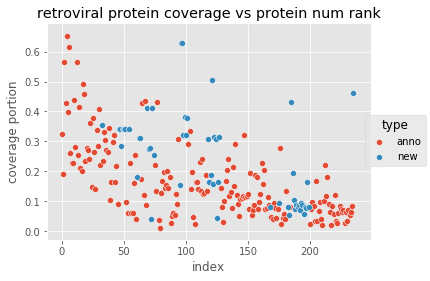

In [94]:
import seaborn as sns
pr_pep_cov_df = retro_rna_pep_df[['new_geneid','cov_per','gename','pep_num','pr_len','type','rna_cs','rna','peps','locis']].append(
                event_virus_pep_cov_df[['new_geneid','cov_per','gename','pep_num','pr_len','type','rna_cs','rna','peps','locis']])
pr_pep_cov_df = pr_pep_cov_df.sort_values('pep_num',ascending=False)
pr_pep_cov_df = pr_pep_cov_df.reset_index(drop=True)
pr_pep_cov_df['x'] = pd.Series(range(pr_pep_cov_df.shape[0]))
pr_pep_cov_df.to_csv(path + '/24_all_vrius_sites_with_peps.txt',sep='\t',index=False)

# rc={'axes.labelsize': 14, 'font.size': 15, 'legend.fontsize': 12, 'axes.titlesize': 18}
# sns.set(rc=rc)
ax = sns.pairplot(x_vars=['x'],y_vars=['cov_per'],data=pr_pep_cov_df, hue='type',size=6)
ax.fig.set_size_inches(6,4)
_ = ax.set(xlabel='index', ylabel='coverage portion',title='retroviral protein coverage vs protein num rank')
plt.subplots_adjust(top=0.9,bottom=0.15)
plt.savefig(path + '/retroviral_pr_cov_portion.png',dpi=200,figsize=(8,6))

In [95]:
# plot histogram of peptide number for each virus sites, this includes peptides from all isoforms 
anno_gene_pep_num_df = known_retro_viral_df[['pep','new_geneid']].drop_duplicates().groupby('new_geneid').count().sort_values('pep',ascending=False)
anno_gene_pep_num_df.reset_index(inplace=True)
anno_gene_pep_num_df['type'] = pd.Series(['anno'] * anno_gene_pep_num_df.shape[0])
new_gene_pep_num_df = event_virus_inter_df[['virus_sites','pep']].drop_duplicates().groupby('virus_sites').count().sort_values('pep',ascending=False)
new_gene_pep_num_df.reset_index(inplace=True)
new_gene_pep_num_df['type'] = pd.Series(['new'] * new_gene_pep_num_df.shape[0])
new_gene_pep_num_df.columns = ['new_geneid','pep','type']
gene_pep_num_df = anno_gene_pep_num_df.append(new_gene_pep_num_df)

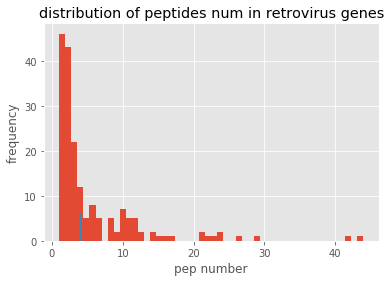

In [96]:
plt.rcParams["figure.figsize"] = (6,4)
axes = gene_pep_num_df.groupby('type')['pep'].hist(alpha=0.4,bins=50)
_ = axes[0].set_title('distribution of peptides num in retrovirus genes')
_ = axes[0].set_xlabel('pep number')
_ = axes[0].set_ylabel('frequency')

Get peptide supported retrovirus

In [97]:
retro_rna_pep_gff_df['new_geneid'] = retro_rna_pep_gff_df['geneid'].map(lambda x: '_'.join(x.split('_')[:2]))

In [98]:
print retro_rna_pep_gff_df[['new_geneid','virus_type']].drop_duplicates()['virus_type'].value_counts()
print event_virus_inter_df[['chr_virus','s_virus','e_virus','virus_type']].drop_duplicates()['virus_type'].value_counts()

C    79
A    67
E    20
B    17
D     4
Name: virus_type, dtype: int64
C    52
D     2
Name: virus_type, dtype: int64


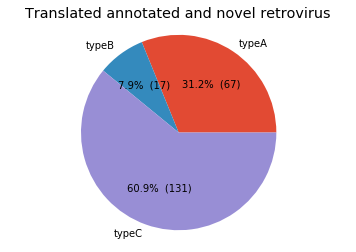

In [99]:
def make_autopct(values):
    def my_autopct(pct):
        total = sum(values)
        val = int(round(pct*total/100.0))
        return '{p:.1f}%  ({v:d})'.format(p=pct,v=val)
    return my_autopct
labels = 'typeA', 'typeB', 'typeC'
sizes = np.array([67, 17, 131])
_ = plt.pie(sizes, labels=labels, autopct=make_autopct(sizes))
_ = plt.axis('equal')
_ = plt.title('Translated annotated and novel retrovirus')
plt.savefig('/data/shangzhong/trans_retro.svg')

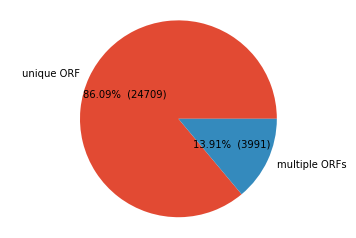

In [100]:
def make_autopct(values):
    def my_autopct(pct):
        total = sum(values)
        val = int(round(pct*total/100.0))
        return '{p:.2f}%  ({v:d})'.format(p=pct,v=val)
    return my_autopct
labels = 'unique ORF', 'multiple ORFs'
sizes = np.array([24709, 3991])
_ = plt.pie(sizes, labels=labels, autopct=make_autopct(sizes))
_ = plt.axis('equal')
_ = plt.title('')

### In paper, they detected typeC retrovirus data
Here we try to identify the complete provirus that have all virus proteins expressed in the genome.The strategy is: 
1. for annotation gets the proteins that belong to type C virus.
2. for new identified virus, get the ones that belong to type C virus.
3. merge 1 and 2.
4. map all the LTR seqeunces of the retroviruses to picr. mapped viruses are 


In [101]:
# {geneid : [peptides]}
known_gid_pep_dic = {k:list(set(v)) for k,v in known_retro_viral_df.groupby('new_geneid')['pep']}
# merge known and novel peptide loci numbers
pep_num_dic = {}
pep_num_dic.update(known_pep_loci_dic)
pep_num_dic.update(event_virus_pep_locis_dic)
# all retrovirus peptide coverage
retro_cov_per_dic = pr_pep_cov_df.set_index('new_geneid')['cov_per'].to_dict()

In [102]:
# 1. get anno typeC virus
# retro_rna_pep_gff_df['virus_type'] = retro_rna_pep_gff_df['full_name'].map(lambda x: virus_type[x])
# retro_rna_pep_gff_df['id'] = retro_rna_pep_gff_df['full_name'].map(lambda x: x.split('|')[1] if '|' in x else '-')
# typeC_ids = ['P03387', 'P03355', 'P0DOG8']
retro_pep_support_rnas = retro_rna_pep_df['rna'].tolist()
typeC_anno_retro_pep_df = retro_rna_pep_gff_df.query('virus_type == "C" and rnaid in @retro_pep_support_rnas')
typeC_anno_retro_pep_df = typeC_anno_retro_pep_df[['chr','cds_s','cds_e','geneid','gename','full_name','virus_type']].reset_index(drop=True)
typeC_anno_retro_pep_df['type'] = pd.Series(['anno'] * typeC_anno_retro_pep_df.shape[0])
typeC_anno_retro_pep_df = typeC_anno_retro_pep_df.rename(columns={'cds_s':'s', 'cds_e':'e'})
typeC_anno_retro_pep_df['geneid'] = typeC_anno_retro_pep_df['geneid'].map(lambda x: modify_geneid(x))
typeC_anno_retro_pep_df['pep'] = typeC_anno_retro_pep_df['geneid'].map(lambda x: ','.join(known_gid_pep_dic[x]))
typeC_anno_retro_pep_df['pep_num'] = typeC_anno_retro_pep_df['pep'].map(lambda x: len(set(x.split(','))))
typeC_anno_retro_pep_df['locis'] = typeC_anno_retro_pep_df['geneid'].map(lambda x: ','.join([str(pep_num_dic[p]) for p in known_gid_pep_dic[x]]))
typeC_anno_retro_pep_df['cov_per'] = typeC_anno_retro_pep_df['geneid'].map(lambda x: retro_cov_per_dic[x])

# get peptides
typeC_anno_genes = typeC_anno_retro_pep_df['geneid'].unique().tolist()
typeC_anno_peps = known_retro_viral_df.query('new_geneid in @typeC_anno_genes')['pep'].unique().tolist()

In [110]:
# 2. get new typeC virus, all of them are typc proteins, so no need to filter them out
novel_gid_pep_dic = {k:list(set(v)) for k,v in event_virus_inter_df.groupby('virus_sites')['pep']}
event_virus_pep_cov_df['virus_pr'] = event_virus_pep_cov_df['full_name'].map(lambda x: x.split()[0])

event_virus_pep_cov_df['chr'] = event_virus_pep_cov_df['new_geneid'].map(lambda x: x.split(':')[0])
event_virus_pep_cov_df['s'] = event_virus_pep_cov_df['new_geneid'].map(lambda x: int(x.split(':')[1]))
event_virus_pep_cov_df['e'] = event_virus_pep_cov_df['new_geneid'].map(lambda x: int(x.split(':')[2]))
typeC_new_retro_pep_df = event_virus_pep_cov_df # .query('new_geneid in @fil_new_retro_sites_ids')
typeC_new_retro_pep_df = typeC_new_retro_pep_df.reset_index()
typeC_new_retro_pep_df['virus_type'] = typeC_new_retro_pep_df['full_name'].map(lambda x: add_high_virus_type(x))
typeC_new_retro_pep_df = typeC_new_retro_pep_df.query('virus_type == "C"')
typeC_new_retro_pep_df['geneid'] = typeC_new_retro_pep_df.apply(lambda x:':'.join([x['chr'],str(x['s']),str(x['e'])]) ,axis=1)
typeC_new_retro_pep_df = typeC_new_retro_pep_df[['chr','s','e','geneid','gename','full_name','virus_type','type']]
typeC_new_retro_pep_df['pep'] = typeC_new_retro_pep_df['geneid'].map(lambda x: ','.join(novel_gid_pep_dic[x]))
typeC_new_retro_pep_df['pep_num'] = typeC_new_retro_pep_df['pep'].map(lambda x: len(set(x.split(','))))
typeC_new_retro_pep_df['locis'] = typeC_new_retro_pep_df['geneid'].map(lambda x: ','.join([str(pep_num_dic[p]) for p in novel_gid_pep_dic[x]]))
typeC_new_retro_pep_df['cov_per'] = typeC_new_retro_pep_df['geneid'].map(lambda x: retro_cov_per_dic[x])
# get peptides
typeC_new_peps = list(set([p for pep in typeC_new_retro_pep_df['pep'] for p in pep.split(',')]))

In [116]:
def sort_df_by_chrom(df):
    df['chr_idx'] = df['chr'].map(lambda x: int(x.split('_')[1]))
    df = df.sort_values('chr_idx')
    del df['chr_idx']
    return df

In [118]:
# 3. merge
all_typeC_df = typeC_anno_retro_pep_df.append(typeC_new_retro_pep_df)
all_typeC_df = all_typeC_df.sort_values(['chr','s']).drop_duplicates()
all_typeC_df['gename'] = all_typeC_df['gename'].str.lower()
all_typeC_df = sort_df_by_chrom(all_typeC_df)
all_typeC_df.to_csv(path + '/21_retro_typeC.txt',sep='\t',index=False)
# add rna
anno_retro_gid_rna_dic = retro_rna_pep_df.set_index('new_geneid')['rna'].to_dict()
all_typeC_df['rna'] = all_typeC_df['geneid'].map(lambda x: anno_retro_gid_rna_dic[x] if x in anno_retro_gid_rna_dic else x)
all_typeC_gid_gnm_dic = all_typeC_df.set_index('geneid')['gename'].to_dict()

In [119]:
# 4. correct cds region for virus
all_typeC_rnas = all_typeC_df['rna'].tolist()
ham_gff_df = pd.read_csv(ham_gff, sep='\t',header=None)
cds_gff_df = ham_gff_df[ham_gff_df[2].values=='CDS']
cds_gff_df = cds_gff_df.reset_index(drop=True)
cds_gff_df['rna'] = cds_gff_df[8].map(lambda x: re.search('(?<=Parent=).+?(?=;)',x).group(0))
cds_gff_df = cds_gff_df.query('rna in @all_typeC_rnas')
cds_gff_df = cds_gff_df.reset_index(drop=True)

In [120]:
rna_cds_pos_dic = {}
for idx, row in cds_gff_df.iterrows():
    if row['rna'] not in rna_cds_pos_dic:
        rna_cds_pos_dic[row['rna']] = [[[row[3], row[4]]], row[6]]
    else:
        rna_cds_pos_dic[row['rna']][0].append([row[3], row[4]])
# sort regions
for k,v in rna_cds_pos_dic.iteritems():
    if v[-1] == '-':
        v[0] = sorted(v[0], key=lambda x: x[0], reverse=True)
    else:
        v[0] = sorted(v[0], key=lambda x: x[0])

In [121]:
all_typeC_df[['geneid','virus_type','gename']].drop_duplicates()['gename'].value_counts()

env                                                    34
gag                                                    24
pol                                                    17
p30 protein [baboon endogenous virus strain             9
ma [abelson murine leukemia                             8
gag-pol                                                 8
ca [moloney murine sarcoma                              7
p30 ca [moloney murine leukemia                         7
p12 protein [baboon endogenous virus strain             4
ca [murine osteosarcoma                                 3
virion core structural peptide p27 [feline leukemia     2
ggag_mlvav                                              2
virion core structural peptide p15 [feline leukemia     2
ma [murine osteosarcoma                                 2
ubiquitin-like protein [murine osteosarcoma             1
Name: gename, dtype: int64

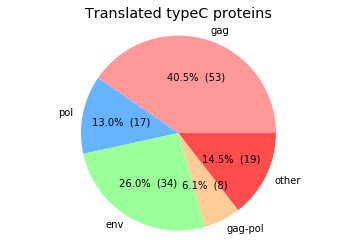

In [122]:
def make_autopct(values):
    def my_autopct(pct):
        total = sum(values)
        val = int(round(pct*total/100.0))
        return '{p:.1f}%  ({v:d})'.format(p=pct,v=val)
    return my_autopct
colors = ['#ff9999','#66b3ff','#99ff99','#ffcc99', '#ff4d4d']
labels = 'gag', 'pol', 'env', 'gag-pol', 'other'
sizes = np.array([53, 17, 34, 8, 19])
_ = plt.pie(sizes, labels=labels, autopct=make_autopct(sizes), colors=colors)
_ = plt.axis('equal')
_ = plt.title('Translated typeC proteins')
plt.savefig('/data/shangzhong/trans_typeC.svg')

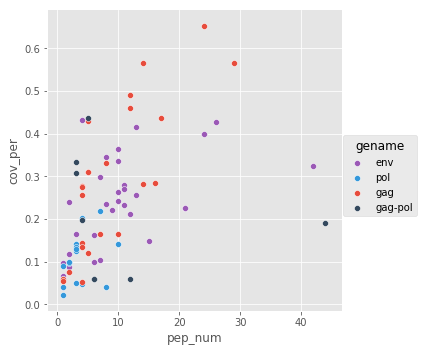

In [123]:
import seaborn as sns
flatui = ["#9b59b6", "#3498db", "#e74c3c", "#34495e"]
genes = ['env','pol','gag','gag-pol']
plt_df = all_typeC_df.query('gename in @genes')
ax = sns.pairplot(x_vars=['pep_num'], y_vars=['cov_per'], data=plt_df, hue='gename',size=5,palette=sns.color_palette(flatui))
plt.savefig('/data/shangzhong/retro_typeC.svg')

In [124]:
high_cf_retro_C_genes_df = all_typeC_df.query('cov_per > 0.1 and pep_num > 20')
high_cf_retro_C_genes_df

,chr,s,e,geneid,gename,full_name,virus_type,type,pep,pep_num,locis,cov_per,rna
71,picr_8,43913321,43914872,gene_28044,env,sp|P03391|ENV_FSVGA Envelope glycoprotein OS=F...,C,anno,"KCNPLILR,KAITPTPGAVTFSPTPDALNIEITR,KDPVTLFSLYR...",26,"8,4,9,8,9,6,9,4,6,5,12,14,13,6,3,4,11,8,11,2,5...",0.428295,asmbl_79241
36,picr_12,34947710,34949711,gene_4642,env,sp|P03391|ENV_FSVGA Envelope glycoprotein OS=F...,C,anno,"DSAGGGGFQGATPGGK,RFSHYIR,RTTWDSPK,KCNPLILR,KEE...",21,"8,2,9,8,13,6,12,11,7,8,8,8,14,9,8,8,9,11,6,2,14",0.226727,asmbl_13621
56,picr_16,28044783,28046784,gene_8519,env,sp|P03391|ENV_FSVGA Envelope glycoprotein OS=F...,C,anno,"DSAGGGGFQGATPGGK,RFSHYIR,RTTWDSPK,KCNPLILR,KEE...",21,"8,2,9,8,13,6,12,11,7,8,8,8,14,9,8,8,9,11,6,2,14",0.226727,asmbl_25133
3,picr_36,17478635,17492643,gene_17239,gag-pol,sp|P03355|POL_MLVMS Gag-Pol polyprotein OS=Mol...,C,anno,"KCNPLILR,KQVTYLGYK,RWGCETTGEAYWKPSSSWDFITLK,KD...",44,"8,7,3,9,7,8,9,13,6,5,9,4,6,1,5,12,8,8,14,3,3,1...",0.190418,asmbl_48822
51,picr_44,12504339,12505368,gene_19658,gag,sp|P03332|GAG_MLVMS Gag polyprotein OS=Moloney...,C,anno,"RPEWDFTTEAGR,RRGPHLDR,RLRQEAEEKEVAR,GAEESPAAFL...",24,"5,8,4,6,6,3,4,6,9,3,11,7,8,2,2,5,5,5,3,9,1,5,3,5",0.652047,asmbl_55255
42,picr_85,742328,743687,gene_28626,env,sp|P03391|ENV_FSVGA Envelope glycoprotein OS=F...,C,anno,"KCNPLILR,RSKDFYVCPGHKPTHGCGGPQEGYCAR,KAITPTPGA...",24,"8,3,4,3,9,9,6,9,4,5,8,8,3,6,3,3,11,8,3,11,5,8,4,6",0.398230,asmbl_80906
19,picr_114,1696556,1698074,gene_3864,gag,sp|Q8UN02|GAG80_MLVMN Glycosylated Gag polypro...,C,anno,"RPEWDFTTEAGR,RRGPHLDR,RLRQEAEEK,GAEESPAAFLER,R...",29,"5,8,7,6,6,3,4,6,9,2,3,11,4,7,8,2,2,5,5,5,3,2,9...",0.566337,asmbl_11243
53,picr_341,37272,95609,gene_16534,env,sp|P03391|ENV_FSVGA Envelope glycoprotein OS=F...,C,anno,"KCNPLILR,KQVTYLGYK,KAITPTPGAVTFSPTPDALNIEITR,R...",42,"8,7,4,3,9,8,9,13,6,5,9,4,6,5,12,8,8,14,3,3,13,...",0.324468,asmbl_46627


In [125]:
# output high confidence retro type C genes
rnas = high_cf_retro_C_genes_df['rna'].tolist()

### Get RNAseq coverage at the virus sites with peptides
many reads mapping to viral sites are actually multi mapping reads, so here for each viral sites, we split the reads into uniquely mapping and multi mapping ones, and then stack them along the viral sites.
1. build a dataframe with columns:  geneid, pos, # of unique reads, # of multi reads

In [126]:
# def keep_secondary_read(aln):
#     if aln.is_secondary:
#         return True
#     else:
#         return False

# def keep_unique_read(aln):
#     if aln.is_secondary:
#         return False
#     else:
#         return True

# def get_coverage(bam_obj, regions):
#     '''get coverage at each base for unique and secondary reads'''
#     uni_cov = bam_obj.count_coverage(regions[0], regions[1], regions[2], read_callback=keep_unique_read)
#     uni_cov = np.sum(np.vstack(uni_cov), axis=0)
#     sec_cov = bam_obj.count_coverage(regions[0], regions[1], regions[2], read_callback=keep_secondary_read)
#     sec_cov = np.sum(np.vstack(sec_cov), axis=0)
#     return uni_cov, sec_cov

# def old_get_count_dic(all_typeC_df, bam_obj, rna_cds_pos_dic):
#     '''output format {geneid: [unique read cov at each position, secondary read cov at each position]}'''
#     count_dic = {}
#     for idx, row in all_typeC_df.iterrows():
#         gene = row['geneid']
#         rna = row['rna']
#         chrom = row['chr']
        
#         if rna.startswith('asmbl'):
#             strand = rna_cds_pos_dic[rna][-1]
#             regions = rna_cds_pos_dic[rna][0]
#         else:
#             strand = '+'
#             regions = [[row['s'], row['e']]]
        
#         res_uni_cov = np.array([])
#         res_sec_cov = np.array([])
#         for region in regions:
#             uni_cov, sec_cov = get_coverage(bam_obj,[chrom, region[0], region[1]])
#             if strand == '-':
#                 uni_cov = np.flip(uni_cov, 0)
#                 sec_cov = np.flip(sec_cov, 0)
#             res_uni_cov = np.concatenate([res_uni_cov, uni_cov])
#             res_sec_cov = np.concatenate([res_sec_cov, sec_cov])
#         count_dic[gene] = [res_uni_cov, res_sec_cov]
#     return count_dic

In [127]:
def get_region_cov(bam_obj, chrom, start, end):
    '''get coverage at each position of a region'''
    uni_cov = {}; sec_cov = {}
    for pile in bam_obj.pileup(chrom, start, end):
        pos = pile.pos
        if start < pos <= end:
            uni = 0; sec = 0
            for read in pile.pileups:
                if read.is_del or read.is_refskip:
                    continue
                nh = read.alignment.get_tags()[0][1]
                if nh == 1:
                    uni += 1
                else:
                    sec += 1
            uni_cov[pos] = uni
            sec_cov[pos] = sec
    uni_cov_lst = []; sec_cov_lst = []
    for p in range(start+1, end+1):
        if p in uni_cov:
            uni_cov_lst.append(uni_cov[p])
        else:
            uni_cov_lst.append(0)
        if p in sec_cov:
            sec_cov_lst.append(sec_cov[p])
        else:
            sec_cov_lst.append(0)
    return uni_cov_lst, sec_cov_lst

In [128]:
def get_count_dic(all_typeC_df, bam_obj, rna_cds_pos_dic):
    '''output format {geneid: [unique read cov at each position, secondary read cov at each position]}'''
    count_dic = {}
    for idx, row in all_typeC_df.iterrows():
        gene = row['geneid']
        rna = row['rna']
        chrom = row['chr']
        if rna.startswith('asmbl'):
            strand = rna_cds_pos_dic[rna][-1]
            regions = rna_cds_pos_dic[rna][0]
        else:
            strand = '+'
            regions = [[row['s'], row['e']]]
        res_uni_cov = []; res_sec_cov = [];
        for region in regions:
            uni_cov, sec_cov = get_region_cov(bam_obj,chrom, region[0], region[1])
            if strand == '-':
                uni_cov = uni_cov[::-1]
                sec_cov = sec_cov[::-1]
            res_uni_cov.extend(uni_cov)
            res_sec_cov.extend(sec_cov)
        count_dic[gene] = [res_uni_cov, res_sec_cov]
    return count_dic

In [129]:
%%time
# get retroviral rnaseq coverage for all bam files
bam_files = natsorted(glob.glob('/data/shangzhong/Proteogenomics/proteogenomics_bam/*.bam'))
count_lst = []
for bam in bam_files:
    bam_obj = pysam.AlignmentFile(bam)
    count_dic = get_count_dic(high_cf_retro_C_genes_df, bam_obj, rna_cds_pos_dic)
    count_lst.append(count_dic)

CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 181 µs


In [130]:
high_cf_retro_C_genes_df.head()

,chr,s,e,geneid,gename,full_name,virus_type,type,pep,pep_num,locis,cov_per,rna
71,picr_8,43913321,43914872,gene_28044,env,sp|P03391|ENV_FSVGA Envelope glycoprotein OS=F...,C,anno,"KCNPLILR,KAITPTPGAVTFSPTPDALNIEITR,KDPVTLFSLYR...",26,"8,4,9,8,9,6,9,4,6,5,12,14,13,6,3,4,11,8,11,2,5...",0.428295,asmbl_79241
36,picr_12,34947710,34949711,gene_4642,env,sp|P03391|ENV_FSVGA Envelope glycoprotein OS=F...,C,anno,"DSAGGGGFQGATPGGK,RFSHYIR,RTTWDSPK,KCNPLILR,KEE...",21,"8,2,9,8,13,6,12,11,7,8,8,8,14,9,8,8,9,11,6,2,14",0.226727,asmbl_13621
56,picr_16,28044783,28046784,gene_8519,env,sp|P03391|ENV_FSVGA Envelope glycoprotein OS=F...,C,anno,"DSAGGGGFQGATPGGK,RFSHYIR,RTTWDSPK,KCNPLILR,KEE...",21,"8,2,9,8,13,6,12,11,7,8,8,8,14,9,8,8,9,11,6,2,14",0.226727,asmbl_25133
3,picr_36,17478635,17492643,gene_17239,gag-pol,sp|P03355|POL_MLVMS Gag-Pol polyprotein OS=Mol...,C,anno,"KCNPLILR,KQVTYLGYK,RWGCETTGEAYWKPSSSWDFITLK,KD...",44,"8,7,3,9,7,8,9,13,6,5,9,4,6,1,5,12,8,8,14,3,3,1...",0.190418,asmbl_48822
51,picr_44,12504339,12505368,gene_19658,gag,sp|P03332|GAG_MLVMS Gag polyprotein OS=Moloney...,C,anno,"RPEWDFTTEAGR,RRGPHLDR,RLRQEAEEKEVAR,GAEESPAAFL...",24,"5,8,4,6,6,3,4,6,9,3,11,7,8,2,2,5,5,5,3,9,1,5,3,5",0.652047,asmbl_55255


In [131]:
plt.rcParams["figure.figsize"] = (16,6)
for idx, row in high_cf_retro_C_genes_df.loc[[56,53],:].iterrows():
    gene = row['geneid']
    rna = anno_retro_gid_rna_dic[gene]
    rna_tpm = cho_retro_quant_df.loc[rna,:].tolist()
    # get most expressed bam file
    fn = cho_retro_quant_df.loc[rna,:].idxmax()
    print fn
    rna_tpm_max = max(rna_tpm)
    max_idx = rna_tpm.index(rna_tpm_max)
    cov = count_lst[max_idx][gene]
    merge = pd.DataFrame({'uni':cov[0], 'sec':cov[1]})
    gnm = all_typeC_gid_gnm_dic[gene]
    ax = merge.plot.area()
    _ = ax.set_title(gene + ':' + gnm + ':' + rna)
    _ = ax.set_xlabel('gene position')
    merge_max = merge.sum(axis=1).max()
    _ = ax.set_ylim(0,merge_max * 1.1)
    # plot peptides
    peps = row['pep'].split(',')
    locis = [int(p) for p in row['locis'].split(',')]
    n = 0
    for p, l in zip(peps, locis):
        if int(l) == 1:
            c = 'r'
        else:
            c = 'g'
        n += 1
#         if n % 2 == 0:
#             y_val = merge_max * 1
#         else:
#             y_val = merge_max * 1.05
        if n % 2 == 0:
            y_val = -75
        else:
            y_val = -75
        try:
            start = known_pep_df_reindex.loc[(rna, p),'pos'] * 3
            end = start + len(p) * 3
            ax.hlines(y = y_val, xmin=start, xmax=end, linewidth=3, color=c)
            ax.set_ylim([-110,190])
        except:
            continue
    plt.savefig('/data/shangzhong/cov.svg')

CellLine7_C


IndexError: list index out of range

In [ ]:
print anno_retro_gid_rna_dic['gene_4642']
print sorted(cho_retro_quant_df.loc['asmbl_13621',:], reverse=True)

In [ ]:
# 4. get virus between ltr regions
all_typeC_bed = BedTool.from_dataframe(all_typeC_df)
all_typeC_in_ltr_df = ltr_bed.intersect(all_typeC_bed, wo=True).to_dataframe(names=['ltr_chr','ltr_s','ltr_e','chr','s','e','genome','full_name','type','len'])

all_typeC_in_ltr_df.to_csv(path + '/22_retro_typeC_in_ltr.txt',sep='\t',index=False)

In [ ]:
# 5. get original file and spectrum of a peptide
def get_original_spectrum_id(res,peps):
    df = pd.read_csv(res, sep='\t', header=0)
    df['pep'] = df['Peptide'].map(lambda x: ''.join([p for p in x if p.isalpha()][:-1]))
    df = df.query('pep in @typeC_anno_peps')
    df = df.reset_index(drop=True)
    return df

known_typeC_res_df = get_original_spectrum_id(event_path + '/known_res.txt', typeC_anno_peps)

In [ ]:
# 6. get original file and spectrum of 
novel_typeC_res_df = get_original_spectrum_id(event_path + '/novel_res.txt', typeC_new_peps)

In [ ]:
test = known_pep_df.query('rna == "asmbl_20943"')
test = test.reset_index(drop=True)
test['end'] = 2939270 - test['pos']*3
test['start'] = test.apply(lambda x: x['end'] - len(x['pep']*3), axis=1)

In [ ]:
test

In [ ]:
known_typeC_res_df.query('Protein == "asmbl_20942"')

Plot pr length, tpm,  cov, type

In [ ]:
merge_viral_genes = pr_pep_cov_df['new_geneid'].unique().tolist()
new_retro_viral_rna_seq_fn = path + '/10_new_retro_viral_rna_seq.fa'
fil_merge_viral_genes = []
for record in SeqIO.parse(new_retro_viral_rna_seq_fn,'fasta'):
    qid = ':'.join(record.id.split(':')[:3])
    if qid in merge_viral_genes:
        pr_seq = str(record.seq.translate())
        if '*' in pr_seq:
            fil_merge_viral_genes.append(qid)
merge_viral_genes = [g for g in merge_viral_genes if (not g.startswith('picr')) or g in fil_merge_viral_genes]

In [ ]:
cho_quant_df = quant_df.iloc[:,range(45)]
cho_quant_df.loc[:,'rna'] = cho_quant_df.index.tolist()
cho_quant_df = cho_quant_df.reset_index(drop=True)
cho_quant_df['geneid'] = cho_quant_df['rna'].map(lambda x: rna_geneid_dic[x] if x in rna_geneid_dic else x)
cho_quant_df['geneid'] = cho_quant_df['geneid'].map(lambda x: modify_geneid(x))
cho_quant_df['geneid'] = cho_quant_df['geneid'].map(lambda x: ':'.join(x.split(':')[:3]) if x.startswith('picr') else x)
del cho_quant_df['rna']
cho_quant_df = cho_quant_df.groupby('geneid').sum()

In [ ]:
cri = cho_quant_df.index.isin(merge_viral_genes)
viral_quant_df = cho_quant_df.iloc[:,range(45)][cri]
viral_quant_df['median'] = viral_quant_df.median(axis=1)
viral_quant_df['mean'] = viral_quant_df.mean(axis=1)
viral_quant_df['new_geneid'] = viral_quant_df.index

In [ ]:
all_feature_df = pd.merge(pr_pep_cov_df,viral_quant_df[['new_geneid','median','mean']],on='new_geneid',how='inner')
del all_feature_df['x']

In [ ]:
from mpl_toolkits.mplot3d import Axes3D
plt.rcParams["figure.figsize"] = (10,8)
ax = plt.figure().gca(projection='3d')
anno_df = all_feature_df.query('type=="anno"')
new_df = all_feature_df.query('type=="new"')
ax.scatter(anno_df['cov_per'],anno_df['pr_len'],anno_df['median'],c='red',label='anno')
ax.scatter(new_df['cov_per'],new_df['pr_len'],new_df['median'],c='blue',label='new')
ax.set_xlabel('coverage')
ax.set_ylabel('protein length')
ax.set_zlabel('tpm')
ax.set_title('evidence for retroviral expression')
_ = ax.set_zlim([0,600])
plt.legend(loc='best')

In [ ]:
plt.rcParams["figure.figsize"] = (10,8)
ax = plt.figure().gca(projection='3d')
env_df = all_feature_df.query('gename=="ENV"')
gag_df = all_feature_df.query('gename=="GAG"')
pol_df = all_feature_df.query('gename=="POL"')
ax.scatter(env_df['cov_per'],env_df['pr_len'],env_df['median'],c='red',label='ENV')
ax.scatter(gag_df['cov_per'],gag_df['pr_len'],gag_df['median'],c='blue',label='GAG')
ax.scatter(pol_df['cov_per'],pol_df['pr_len'],pol_df['median'],c='yellow',label='POL')
ax.set_xlabel('coverage')
ax.set_ylabel('protein length')
ax.set_zlabel('tpm')
ax.set_title('evidence for each retroviral gene type')
plt.legend()
plt.rcParams["figure.figsize"] = (6,4)

In [ ]:
all_feature_df.to_csv(path+'/20_virus_cov_tpm.txt',sep='\t',index=False)

##### Next, we remove peptides from most abundant to least abundant and check how many are still supported by two or more peptides

In [ ]:
def get_gene_pep_num_dic(known_retro_viral_df):
    # {gene : [[num, pep]]}
    gene_pep_num_dic = {}
    pep_gene_num_dic = known_retro_viral_df[['pep','new_geneid']]\
                .drop_duplicates().groupby('pep').count().to_dict()['new_geneid']
    for idx,row in known_retro_viral_df.iterrows():
        key = row['new_geneid']
        pep = row['pep']
        num = pep_gene_num_dic[pep]
        if key not in gene_pep_num_dic:
            gene_pep_num_dic[key] = [[num,pep]]
        else:
            gene_pep_num_dic[key].append([num,pep])
    return gene_pep_num_dic

gene_pep_num_dic = get_gene_pep_num_dic(known_retro_viral_df)

In [ ]:
def get_gene_vs_ko_pep(known_retro_viral_df,retro_rna_pep_df):
    '''this function plots number of genes with more than 1 peptides vs number of peptides removed.
    '''
    known_retro_viral_df['new_geneid'] = known_retro_viral_df['geneid'].map(lambda x: modify_geneid(x))
    # get {peptide : # of genes the peptide map to}
    pep_gene_dic = {k:list(v) for k,v in known_retro_viral_df[['pep','new_geneid']].drop_duplicates().groupby('pep')['new_geneid']}
    pep_gene_num_dic = {k:len(list(v)) for k,v in pep_gene_dic.iteritems()}

    # {gene : [[num, pep]]}
    gene_pep_num_dic = get_gene_pep_num_dic(known_retro_viral_df)
    # in {gene : [[num, pep]]} sort by num
    for k,v in gene_pep_num_dic.iteritems():
        v = sorted(v,key=lambda x:x[0],reverse=True)
        gene_pep_num_dic[k] = v
    # determine order of peptide to remove
    pep_rm_order = []
    for gene in retro_rna_pep_df['new_geneid']:
        for g in gene_pep_num_dic[gene]:
            pep = g[1]
            if pep not in pep_rm_order:
                pep_rm_order.append(pep)

    # import copy
    new_df = known_retro_viral_df
    x = range(len(pep_rm_order) + 1)
    y = [] # gene number with more than 2 peptides
    for p in ['no'] + pep_rm_order:
        new_df = new_df.query('pep != @p')
        new_df = new_df.reset_index(drop=True)
        y.append(new_df[['new_geneid','pep']].drop_duplicates().groupby('new_geneid')\
                 .count().query('pep > 1').shape[0])
    return x,y

x,y = get_gene_vs_ko_pep(known_retro_viral_df,retro_rna_pep_df)

In [ ]:
ax = plt.plot(x,y)
_ = plt.title('gene num with more than 2 peptides VS remove peptides')
_ = plt.xlabel('index of peptides')
_ = plt.ylabel('gene number')

In [ ]:
def get_ko_gene_vs_ko_top_pep(retro_rna_pep_df, gene_pep_num_dic, pep_gene_dic):
    '''
    1. for each gene I got it's top peptide, here top means the peptide maps to the most genes.
    2. start with the most abundant gene,  remove the top peptide, then remove the genes that share the peptide.
    3. for the remaining genes, start with the most abundant and remove the top peptide.
    4. repeat 2-3 until all the genes are knock out.
    '''
    genes = retro_rna_pep_df['new_geneid'].tolist()
    gene_top_peps = [gene_pep_num_dic[g][0][1] for g in genes]
    x = [0]
    y = [len(genes)]
    n = 1
    while genes !=[]:
        gene = genes[0]
        top_pep = gene_top_peps[0]
        rm_genes = pep_gene_dic[top_pep]
        idxes = sorted([genes.index(g) for g in rm_genes if g in genes],reverse=True)
        for i in idxes:
            del genes[i]
            del gene_top_peps[i]
        x.append(n)
        y.append(len(genes))
        n += 1
    return x,y    

pep_gene_dic = {k:list(v) for k,v in known_retro_viral_df[['pep','new_geneid']].drop_duplicates().groupby('pep')['new_geneid']}
x,y = get_ko_gene_vs_ko_top_pep(retro_rna_pep_df, gene_pep_num_dic, pep_gene_dic)
ax = plt.plot(x,y)
_ = plt.title('knocked out genes VS peptide removal')
_ = plt.xlabel('index of peptides')
_ = plt.ylabel('knocked out genes')

In [ ]:
def get_ko_genes_vs_left_peptides(known_retro_viral_df,gene_pep_num_dic):
    '''this function 
    1. start from most abundant genes, remove all the peptides in the gene.
    2. get number of peptides remained.
    '''
    peptides = known_retro_viral_df['pep'].unique().tolist()
    genes = retro_rna_pep_df['new_geneid'].tolist()
    x = range(len(genes) + 1)
    y = [len(peptides)]

    for gene in genes:
        for p in gene_pep_num_dic[gene]:
            try:
                peptides = [pep for pep in peptides if pep != p[1]]
            except:
                pass
        y.append(len(peptides))

    return x,y

x,y = get_ko_genes_vs_left_peptides(known_retro_viral_df,gene_pep_num_dic)
ax = plt.plot(x,y)
_ = plt.title('knocked out genes VS peptide remained')
_ = plt.xlabel('index of genes')
_ = plt.ylabel('number of unique peptides')

all annotated retrovirus -> anno_viral_rnas<br>
all annotated retrovirus with peptides support -> anno_viral_rnas_with_pep<br>
all annotated retrovirus in ltr -> anno_retro_rnas_in_ltr<br>
novel retrovirus sites -> new_retro_rna_sites<br>
novel retrovirus sites that have pepetides support -> new_retro_rna_pep_sites<br>
novel retrovirus sites that have peptides and ltr support -> new_retro_rna_ltr_pep_sites<br>
use flags similar to sam file flag to indicate rnas:<br>

| anno (0)   | new (1) |
|------------|---------|
| no_pep (0) | pep (2) |
| no_ltr (0) | ltr (4) |

In [ ]:
def assign_gene_flag(gene,anno_viral_rnas_with_pep,anno_retro_rnas_in_ltr,\
                     new_retro_rna_sites,new_retro_rna_pep_sites,new_retro_rna_ltr_sites):
    '''this function assigns flags which determines the category of each gene'''
    flag = 0
    if gene in new_retro_rna_sites:
        flag += 1
    pep = new_retro_rna_pep_sites + anno_viral_rnas_with_pep
    if gene in pep:
        flag += 2
    ltr = anno_retro_rnas_in_ltr + new_retro_rna_ltr_sites
    if gene in ltr:
        flag += 4
    return flag

In [ ]:
all_retro_rnas = anno_viral_rnas + new_retro_rna_sites
retro_quant_df = quant_df.loc[all_retro_rnas,]
retro_quant_df = retro_quant_df.fillna(0)
# retro_quant_df['flag'] = retro_quant_df.index.map(lambda x:assign_gene_flag(x,anno_viral_rnas_with_pep,anno_retro_rnas_in_ltr,\
#                       new_retro_rna_sites,new_retro_rna_pep_sites,new_retro_rna_ltr_sites))

In [ ]:
import numpy as np
log_quant_df = (retro_quant_df+0.01).apply(np.log10)
log_quant_df['flag'] = log_quant_df.index.map(lambda x:assign_gene_flag(x,anno_viral_rnas_with_pep,anno_retro_rnas_in_ltr,\
                      new_retro_rna_sites,new_retro_rna_pep_sites,new_retro_rna_ltr_sites))

In [ ]:
log_quant_df['flag'].value_counts()

In [ ]:
def tpm_boxplot(df,title):
    ax = df.boxplot(figsize=(19,6))
    _ = plt.xticks(rotation=90)
    _ = ax.set_title(title)
    _ = ax.set_ylabel('log10 tpm')
    
def tpm_lineplot(df,title):
    ax = df.T.plot(figsize=(19,6))
    _ = plt.xticks(rotation=90)
    _ = ax.set_title(title)
#     _ = ax.set_ylim([0,1000])
    _ = ax.set_ylabel('log10 tpm')

In [ ]:
for f in range(8):
    f = str(f)
    plt.figure(figsize=(19,6))
    ax = tpm_boxplot(log_quant_df.query('[{f}] in flag'.format(f=f)).iloc[:,range(68)],f)

In [ ]:
for f in range(7,8):
    f = str(f)
    plt.figure(figsize=(19,6))
    ax = tpm_lineplot(log_quant_df.query('[{f}] in flag'.format(f=f)).iloc[:,range(68)],f)

In [ ]:
# rna_index = SeqIO.index('/data/shangzhong/Picr_assembly/Annotation/PASA/pasa_stringtie/03_pasa_stringtie_rna.fa','fasta')

# with open('/data/shangzhong/anno_virus.fa', 'w') as out:
#     for rna in anno_viral_rnas:
#         record = rna_index[rna]
#         des =  record.description
#         try:
#             cds = re.search('(?<=CDS=).+?(?=$)',des).group(0).split('-')
#             record.seq = record.seq[int(cds[0])-1:int(cds[1])]
#             SeqIO.write(record, out, 'fasta')
#         except:
#             pass

# ref_index = SeqIO.index('/data/shangzhong/Proteogenomics/virus/10_new_retro_viral_rna_seq.fa','fasta')
# with open('/data/shangzhong/new_virus.fa','w') as out:
#     for head in (high_virus2picr_df['head'] + ':' + high_virus2picr_df['strand']).unique():
#         SeqIO.write(ref_index[head], out, 'fasta')

# witn open('/data/shangzhong/new_virus.fa','w') as out:
#     for head in high_virus2picr_df['head']:
#         item = head.split(':')
#         seq = ref_index[item[0]].seq[int(item[1]):]
    
# high_virus2picr_df.head()